![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "GO-Brazil"
infer_parameters_from_data = True
results_suffix = ".go-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,76,2,781,29,7018354.0,NaN,11715,NaN
2020-05-01,27,0,808,29,7018354.0,NaN,12120,NaN
2020-05-02,17,1,825,30,7018354.0,NaN,12375,NaN
2020-05-03,25,0,850,30,7018354.0,NaN,12750,NaN
2020-05-04,0,0,850,30,7018354.0,NaN,12750,NaN


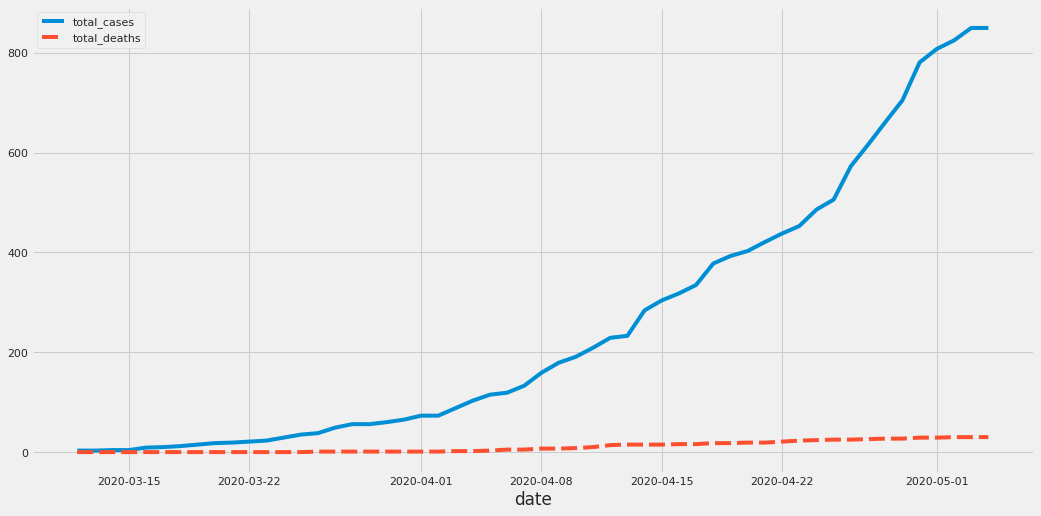

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

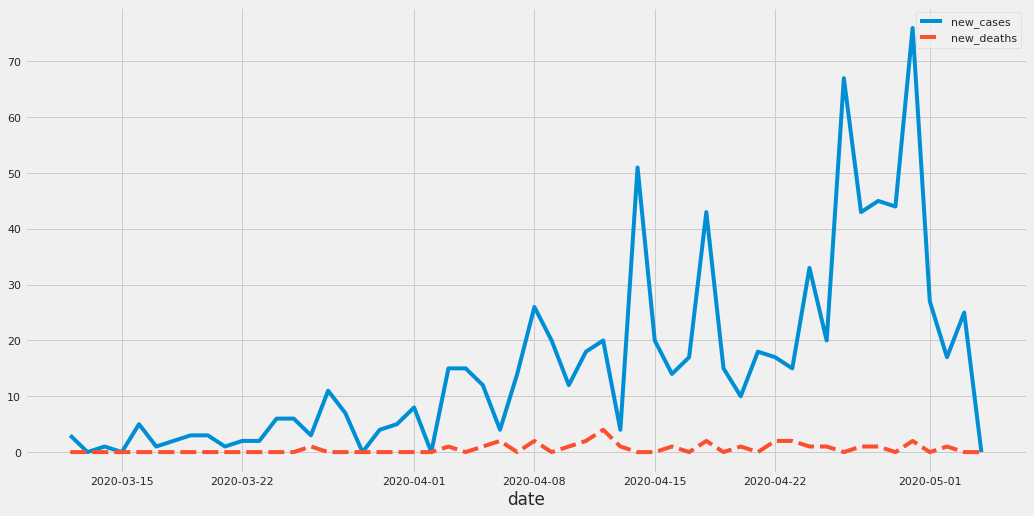

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-03-28 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-03-28 00:00:00, population_size=7018354.0, initially_infected=840.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-28,7.017514e+06,840.000000,0.000000,0.000000,0.000000,0.000000,0.000000,840.000000,840.000000
2020-03-29,7.017514e+06,84.000000,0.000000,756.000000,756.000000,0.000000,0.000000,840.000000,840.000000
2020-03-30,7.016909e+06,613.127614,604.727614,604.800000,75.600000,226.800000,226.800000,1217.927614,1444.727614
2020-03-31,7.016426e+06,545.053163,483.740402,975.174852,551.814852,408.240000,181.440000,1520.228015,1928.468015
2020-04-01,7.015646e+06,834.430835,779.925519,1173.170243,490.547847,700.792456,292.552456,2007.601079,2708.393534


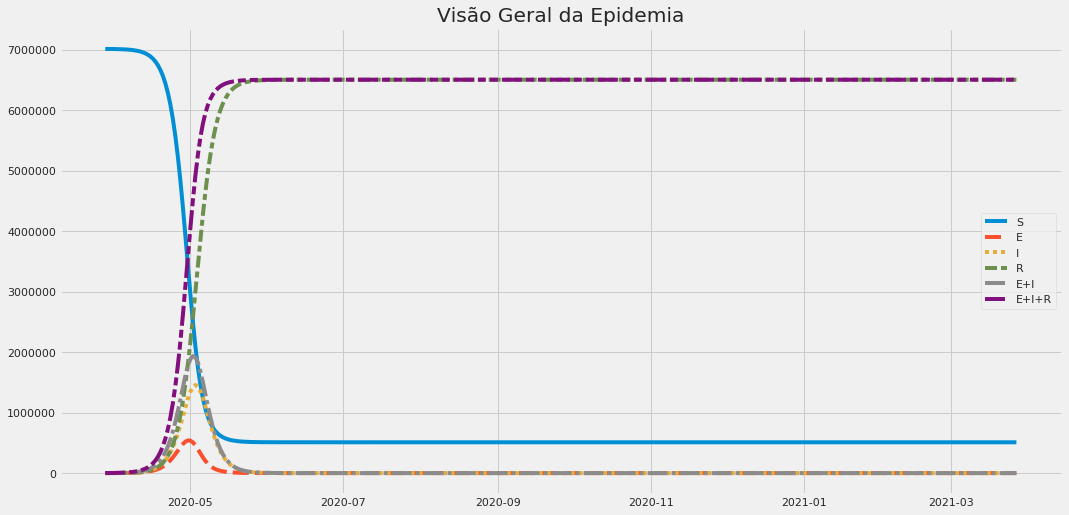

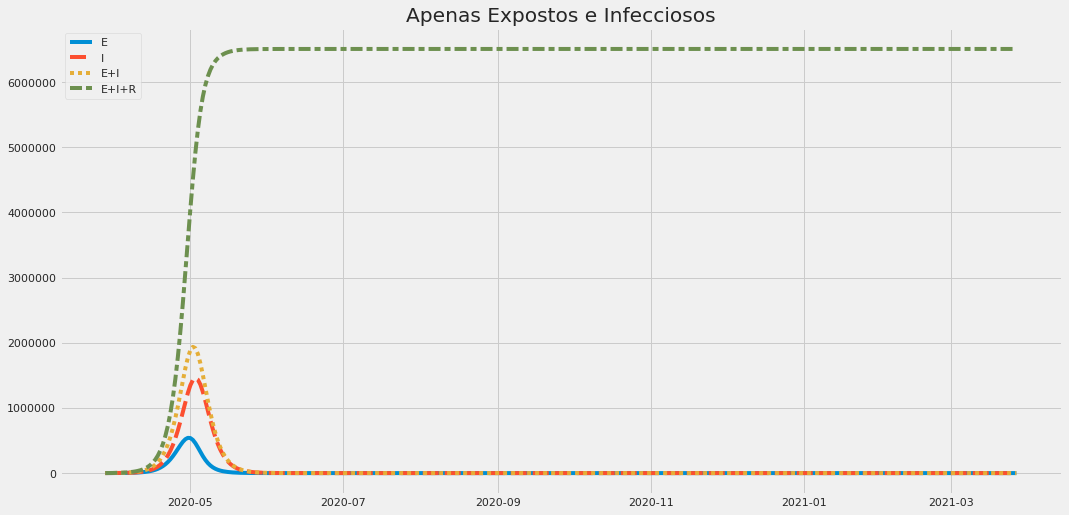

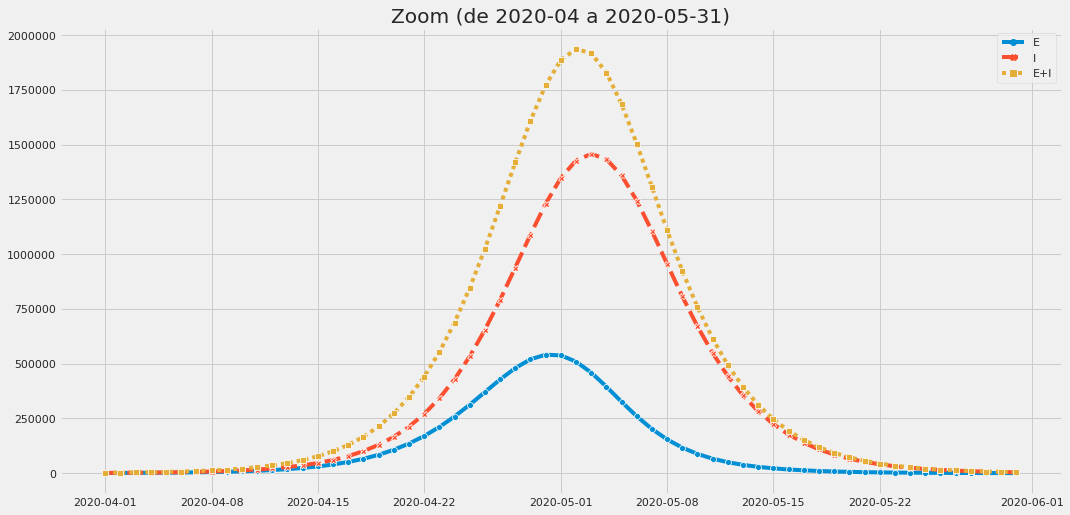

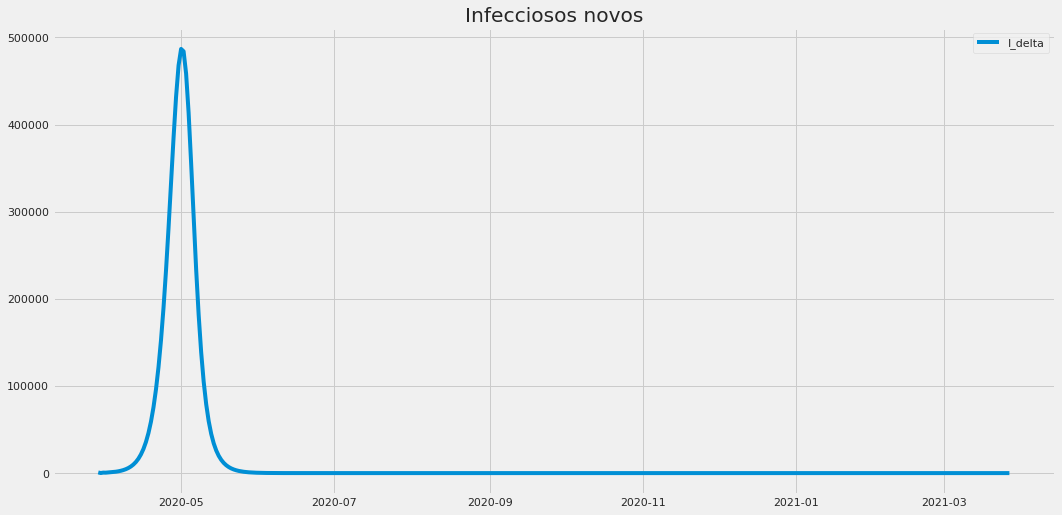

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

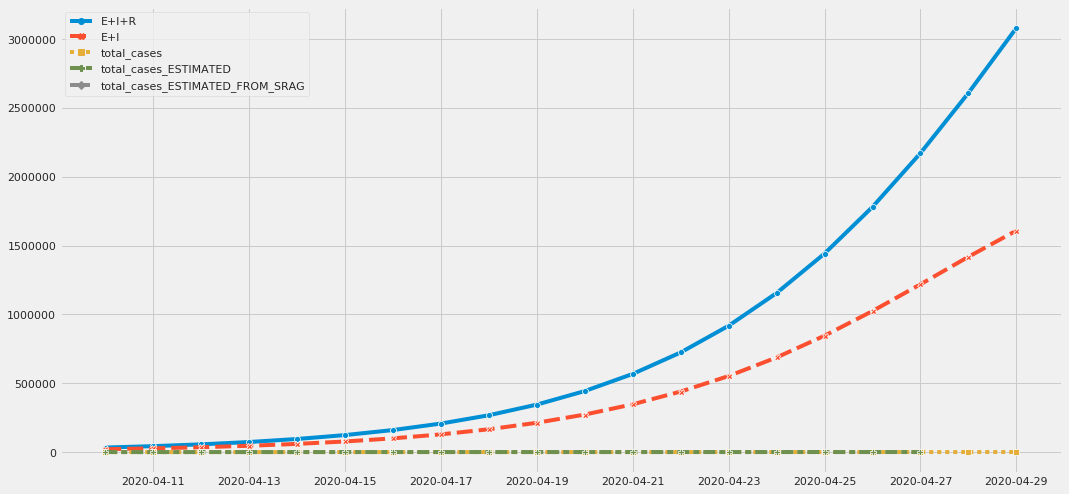

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-28,7.017514e+06,840.000000,0.000000,0.000000,0.000000,0.000000,0.000000,840.000000,840.000000
2020-03-29,7.017514e+06,0.000000,0.000000,840.000000,840.000000,0.000000,0.000000,840.000000,840.000000
2020-03-30,7.016758e+06,755.909517,755.909517,504.000000,0.000000,336.000000,336.000000,1259.909517,1595.909517
2020-03-31,7.016305e+06,453.496856,453.496856,1058.309517,755.909517,537.600000,201.600000,1511.806373,2049.406373
2020-04-01,7.015352e+06,952.200435,952.200435,1088.482566,453.496856,960.923807,423.323807,2040.683001,3001.606808


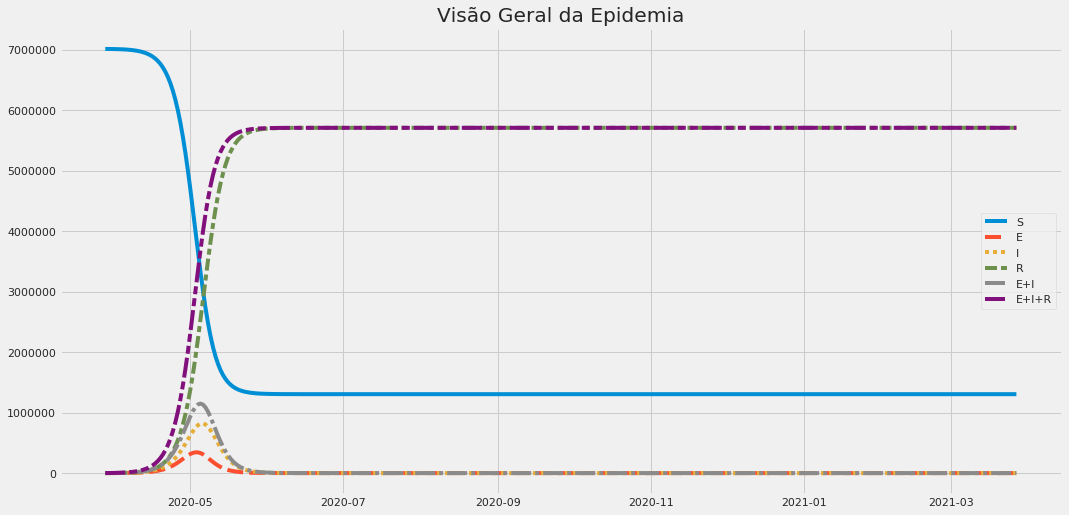

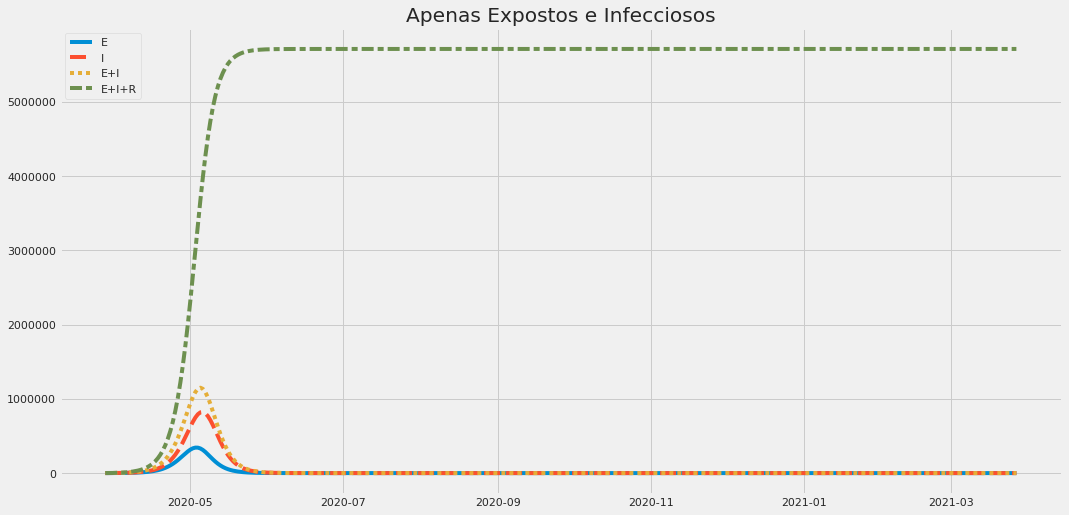

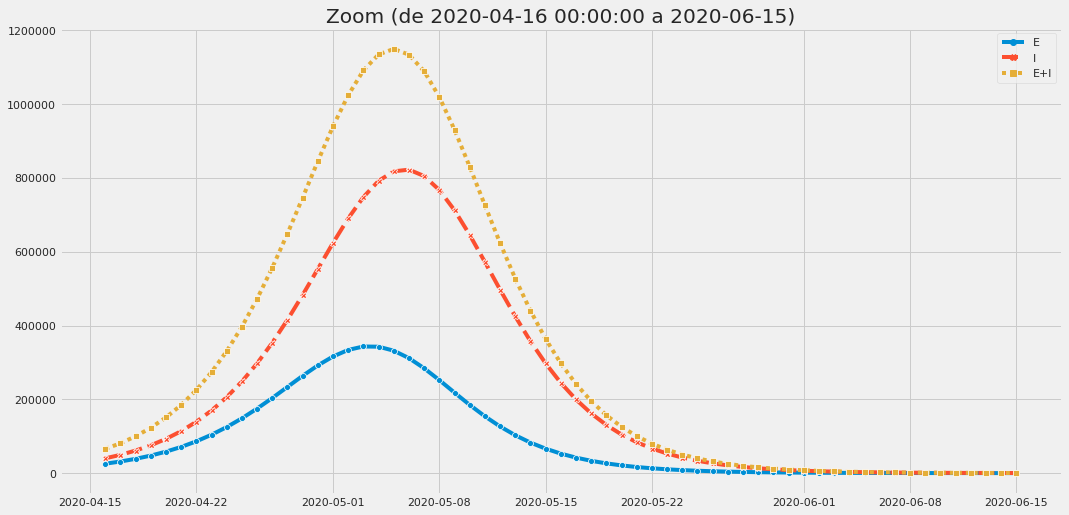

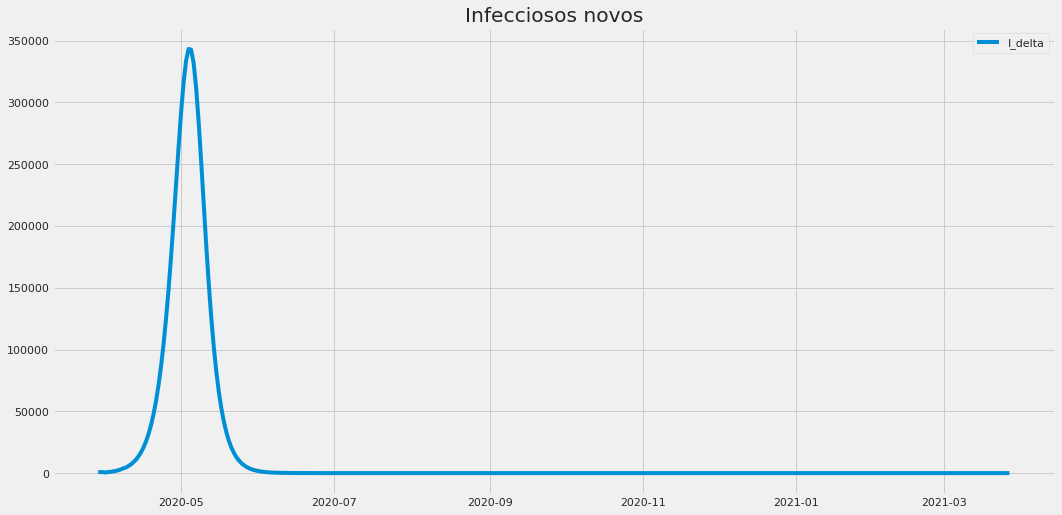

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

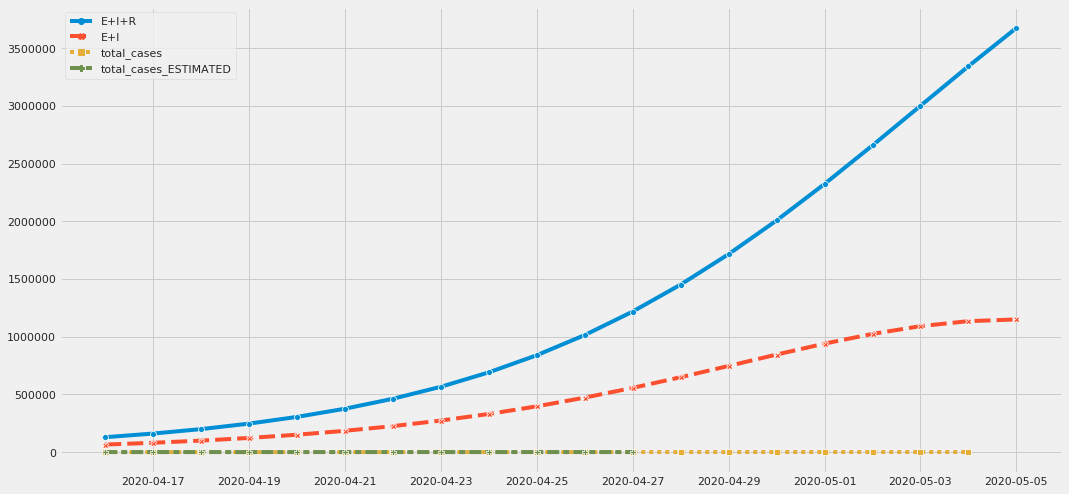

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 11/1000 [00:00<00:09, 108.80trial/s, best loss: 258.72216511493724]

  2%|▏         | 23/1000 [00:00<00:08, 109.27trial/s, best loss: 258.72216511493724]

  3%|▎         | 32/1000 [00:00<00:09, 102.45trial/s, best loss: 258.72216511493724]

  4%|▍         | 41/1000 [00:00<00:09, 97.58trial/s, best loss: 107.44967580820042] 

  5%|▌         | 51/1000 [00:00<00:09, 95.29trial/s, best loss: 107.44967580820042]

  6%|▌         | 60/1000 [00:00<00:10, 92.76trial/s, best loss: 107.44967580820042]

  7%|▋         | 69/1000 [00:00<00:10, 90.99trial/s, best loss: 107.44967580820042]

  8%|▊         | 78/1000 [00:00<00:10, 85.00trial/s, best loss: 107.44967580820042]

  9%|▊         | 86/1000 [00:00<00:11, 81.74trial/s, best loss: 107.44967580820042]

  9%|▉         | 94/1000 [00:01<00:11, 78.40trial/s, best loss: 107.44967580820042]

 10%|█         | 102/1000 [00:01<00:11, 76.29trial/s, best loss: 107.44967580820042]

 11%|█         | 110/1000 [00:01<00:11, 76.19trial/s, best loss: 107.44967580820042]

 12%|█▏        | 118/1000 [00:01<00:11, 74.27trial/s, best loss: 93.68796841149883] 

 13%|█▎        | 126/1000 [00:01<00:11, 73.36trial/s, best loss: 93.68796841149883]

 13%|█▎        | 134/1000 [00:01<00:12, 67.54trial/s, best loss: 93.68796841149883]

 14%|█▍        | 141/1000 [00:01<00:14, 61.30trial/s, best loss: 93.68796841149883]

 15%|█▍        | 148/1000 [00:01<00:13, 63.34trial/s, best loss: 86.12645917689525]

 16%|█▌        | 157/1000 [00:02<00:12, 68.10trial/s, best loss: 86.12645917689525]

 16%|█▋        | 165/1000 [00:02<00:14, 59.12trial/s, best loss: 86.12645917689525]

 17%|█▋        | 172/1000 [00:02<00:14, 56.97trial/s, best loss: 86.12645917689525]

 18%|█▊        | 180/1000 [00:02<00:13, 60.76trial/s, best loss: 86.12645917689525]

 19%|█▉        | 189/1000 [00:02<00:12, 65.72trial/s, best loss: 86.12645917689525]

 20%|█▉        | 198/1000 [00:02<00:11, 69.18trial/s, best loss: 86.12645917689525]

 21%|██        | 206/1000 [00:02<00:11, 69.19trial/s, best loss: 86.12645917689525]

 21%|██▏       | 214/1000 [00:02<00:12, 63.25trial/s, best loss: 86.12645917689525]

 22%|██▏       | 221/1000 [00:03<00:12, 62.22trial/s, best loss: 86.12645917689525]

 23%|██▎       | 229/1000 [00:03<00:11, 65.76trial/s, best loss: 86.12645917689525]

 24%|██▎       | 236/1000 [00:03<00:11, 66.95trial/s, best loss: 86.12645917689525]

 24%|██▍       | 244/1000 [00:03<00:10, 69.53trial/s, best loss: 86.12645917689525]

 25%|██▌       | 252/1000 [00:03<00:10, 71.28trial/s, best loss: 86.12645917689525]

 26%|██▌       | 260/1000 [00:03<00:10, 72.68trial/s, best loss: 86.12645917689525]

 27%|██▋       | 268/1000 [00:03<00:10, 72.64trial/s, best loss: 86.12645917689525]

 28%|██▊       | 276/1000 [00:03<00:09, 72.59trial/s, best loss: 86.12645917689525]

 28%|██▊       | 284/1000 [00:03<00:10, 67.22trial/s, best loss: 86.12645917689525]

 29%|██▉       | 291/1000 [00:04<00:10, 65.57trial/s, best loss: 86.12645917689525]

 30%|██▉       | 299/1000 [00:04<00:10, 67.70trial/s, best loss: 57.98687130521489]

 31%|███       | 306/1000 [00:04<00:10, 68.21trial/s, best loss: 57.98687130521489]

 31%|███▏      | 314/1000 [00:04<00:09, 69.24trial/s, best loss: 57.98687130521489]

 32%|███▏      | 321/1000 [00:04<00:09, 68.80trial/s, best loss: 57.98687130521489]

 33%|███▎      | 328/1000 [00:04<00:09, 68.74trial/s, best loss: 57.98687130521489]

 34%|███▎      | 336/1000 [00:04<00:09, 70.27trial/s, best loss: 57.98687130521489]

 34%|███▍      | 344/1000 [00:04<00:09, 70.44trial/s, best loss: 57.98687130521489]

 35%|███▌      | 352/1000 [00:04<00:09, 70.15trial/s, best loss: 57.98687130521489]

 36%|███▌      | 360/1000 [00:05<00:09, 69.87trial/s, best loss: 57.98687130521489]

 37%|███▋      | 367/1000 [00:05<00:09, 67.50trial/s, best loss: 57.98687130521489]

 37%|███▋      | 374/1000 [00:05<00:09, 66.83trial/s, best loss: 57.98687130521489]

 38%|███▊      | 381/1000 [00:05<00:10, 57.35trial/s, best loss: 57.98687130521489]

 39%|███▉      | 388/1000 [00:05<00:10, 59.41trial/s, best loss: 57.98687130521489]

 40%|███▉      | 395/1000 [00:05<00:09, 61.47trial/s, best loss: 57.98687130521489]

 40%|████      | 402/1000 [00:05<00:09, 62.72trial/s, best loss: 57.98687130521489]

 41%|████      | 409/1000 [00:05<00:10, 57.95trial/s, best loss: 57.98687130521489]

 42%|████▏     | 415/1000 [00:05<00:10, 56.45trial/s, best loss: 57.98687130521489]

 42%|████▏     | 421/1000 [00:06<00:10, 57.40trial/s, best loss: 57.98687130521489]

 43%|████▎     | 428/1000 [00:06<00:09, 59.63trial/s, best loss: 57.98687130521489]

 44%|████▎     | 435/1000 [00:06<00:09, 60.24trial/s, best loss: 57.98687130521489]

 44%|████▍     | 442/1000 [00:06<00:09, 61.17trial/s, best loss: 57.98687130521489]

 45%|████▍     | 449/1000 [00:06<00:08, 61.30trial/s, best loss: 57.98687130521489]

 46%|████▌     | 456/1000 [00:06<00:08, 61.53trial/s, best loss: 57.98687130521489]

 46%|████▋     | 463/1000 [00:06<00:08, 61.65trial/s, best loss: 57.98687130521489]

 47%|████▋     | 470/1000 [00:06<00:08, 61.73trial/s, best loss: 57.98687130521489]

 48%|████▊     | 477/1000 [00:06<00:08, 61.81trial/s, best loss: 57.98687130521489]

 48%|████▊     | 484/1000 [00:07<00:08, 58.36trial/s, best loss: 57.98687130521489]

 49%|████▉     | 491/1000 [00:07<00:08, 59.17trial/s, best loss: 57.98687130521489]

 50%|████▉     | 497/1000 [00:07<00:08, 58.87trial/s, best loss: 57.98687130521489]

 50%|█████     | 504/1000 [00:07<00:08, 59.22trial/s, best loss: 57.98687130521489]

 51%|█████     | 511/1000 [00:07<00:08, 59.63trial/s, best loss: 57.98687130521489]

 52%|█████▏    | 518/1000 [00:07<00:08, 59.85trial/s, best loss: 57.98687130521489]

 52%|█████▏    | 524/1000 [00:07<00:08, 58.37trial/s, best loss: 57.98687130521489]

 53%|█████▎    | 530/1000 [00:07<00:08, 58.65trial/s, best loss: 57.98687130521489]

 54%|█████▎    | 536/1000 [00:07<00:07, 58.53trial/s, best loss: 57.98687130521489]

 54%|█████▍    | 542/1000 [00:08<00:07, 57.53trial/s, best loss: 57.98687130521489]

 55%|█████▍    | 548/1000 [00:08<00:07, 57.05trial/s, best loss: 57.98687130521489]

 55%|█████▌    | 554/1000 [00:08<00:07, 56.01trial/s, best loss: 57.98687130521489]

 56%|█████▌    | 560/1000 [00:08<00:07, 55.50trial/s, best loss: 57.98687130521489]

 57%|█████▋    | 566/1000 [00:08<00:07, 55.63trial/s, best loss: 57.98687130521489]

 57%|█████▋    | 572/1000 [00:08<00:07, 56.52trial/s, best loss: 57.98687130521489]

 58%|█████▊    | 578/1000 [00:08<00:07, 56.69trial/s, best loss: 57.98687130521489]

 58%|█████▊    | 584/1000 [00:08<00:07, 57.19trial/s, best loss: 57.98687130521489]

 59%|█████▉    | 590/1000 [00:08<00:07, 57.41trial/s, best loss: 57.98687130521489]

 60%|█████▉    | 596/1000 [00:09<00:07, 55.35trial/s, best loss: 57.98687130521489]

 60%|██████    | 602/1000 [00:09<00:07, 56.53trial/s, best loss: 57.98687130521489]

 61%|██████    | 608/1000 [00:09<00:07, 55.58trial/s, best loss: 57.98687130521489]

 61%|██████▏   | 614/1000 [00:09<00:06, 56.23trial/s, best loss: 57.98687130521489]

 62%|██████▏   | 620/1000 [00:09<00:06, 54.29trial/s, best loss: 57.98687130521489]

 63%|██████▎   | 626/1000 [00:09<00:07, 50.87trial/s, best loss: 57.98687130521489]

 63%|██████▎   | 632/1000 [00:09<00:07, 52.25trial/s, best loss: 57.98687130521489]

 64%|██████▍   | 638/1000 [00:09<00:06, 53.71trial/s, best loss: 57.98687130521489]

 64%|██████▍   | 644/1000 [00:09<00:06, 53.90trial/s, best loss: 57.98687130521489]

 65%|██████▌   | 650/1000 [00:10<00:06, 52.00trial/s, best loss: 57.98687130521489]

 66%|██████▌   | 656/1000 [00:10<00:06, 53.55trial/s, best loss: 57.98687130521489]

 66%|██████▌   | 662/1000 [00:10<00:06, 53.69trial/s, best loss: 57.98687130521489]

 67%|██████▋   | 668/1000 [00:10<00:06, 54.62trial/s, best loss: 57.98687130521489]

 67%|██████▋   | 674/1000 [00:10<00:05, 55.25trial/s, best loss: 57.98687130521489]

 68%|██████▊   | 680/1000 [00:10<00:05, 55.85trial/s, best loss: 57.98687130521489]

 69%|██████▊   | 686/1000 [00:10<00:05, 55.61trial/s, best loss: 57.98687130521489]

 69%|██████▉   | 692/1000 [00:10<00:05, 55.17trial/s, best loss: 57.98687130521489]

 70%|██████▉   | 698/1000 [00:10<00:05, 54.26trial/s, best loss: 57.98687130521489]

 70%|███████   | 704/1000 [00:11<00:05, 52.83trial/s, best loss: 57.98687130521489]

 71%|███████   | 710/1000 [00:11<00:05, 53.37trial/s, best loss: 57.98687130521489]

 72%|███████▏  | 716/1000 [00:11<00:05, 47.83trial/s, best loss: 57.98687130521489]

 72%|███████▏  | 722/1000 [00:11<00:05, 49.59trial/s, best loss: 57.98687130521489]

 73%|███████▎  | 728/1000 [00:11<00:05, 50.79trial/s, best loss: 57.98687130521489]

 73%|███████▎  | 734/1000 [00:11<00:05, 51.89trial/s, best loss: 57.98687130521489]

 74%|███████▍  | 740/1000 [00:11<00:04, 52.58trial/s, best loss: 57.98687130521489]

 75%|███████▍  | 746/1000 [00:11<00:04, 53.00trial/s, best loss: 57.98687130521489]

 75%|███████▌  | 752/1000 [00:12<00:05, 48.54trial/s, best loss: 57.98687130521489]

 76%|███████▌  | 758/1000 [00:12<00:04, 49.89trial/s, best loss: 57.98687130521489]

 76%|███████▋  | 764/1000 [00:12<00:04, 50.55trial/s, best loss: 57.98687130521489]

 77%|███████▋  | 770/1000 [00:12<00:04, 51.19trial/s, best loss: 57.98687130521489]

 78%|███████▊  | 776/1000 [00:12<00:04, 51.86trial/s, best loss: 57.98687130521489]

 78%|███████▊  | 782/1000 [00:12<00:04, 50.30trial/s, best loss: 57.98687130521489]

 79%|███████▉  | 788/1000 [00:12<00:04, 48.95trial/s, best loss: 57.98687130521489]

 79%|███████▉  | 794/1000 [00:12<00:04, 50.02trial/s, best loss: 57.98687130521489]

 80%|████████  | 800/1000 [00:12<00:03, 50.65trial/s, best loss: 57.98687130521489]

 81%|████████  | 806/1000 [00:13<00:03, 49.83trial/s, best loss: 57.98687130521489]

 81%|████████  | 812/1000 [00:13<00:03, 50.67trial/s, best loss: 57.98687130521489]

 82%|████████▏ | 818/1000 [00:13<00:03, 50.69trial/s, best loss: 57.98687130521489]

 82%|████████▏ | 824/1000 [00:13<00:03, 51.24trial/s, best loss: 57.98687130521489]

 83%|████████▎ | 830/1000 [00:13<00:03, 51.70trial/s, best loss: 57.98687130521489]

 84%|████████▎ | 836/1000 [00:13<00:03, 52.06trial/s, best loss: 57.98687130521489]

 84%|████████▍ | 842/1000 [00:13<00:03, 52.01trial/s, best loss: 57.98687130521489]

 85%|████████▍ | 848/1000 [00:13<00:02, 52.12trial/s, best loss: 57.98687130521489]

 85%|████████▌ | 854/1000 [00:14<00:02, 51.26trial/s, best loss: 57.98687130521489]

 86%|████████▌ | 860/1000 [00:14<00:02, 49.65trial/s, best loss: 57.98687130521489]

 86%|████████▋ | 865/1000 [00:14<00:03, 43.77trial/s, best loss: 57.98687130521489]

 87%|████████▋ | 871/1000 [00:14<00:02, 45.82trial/s, best loss: 57.98687130521489]

 88%|████████▊ | 877/1000 [00:14<00:02, 47.29trial/s, best loss: 57.98687130521489]

 88%|████████▊ | 882/1000 [00:14<00:02, 47.51trial/s, best loss: 57.98687130521489]

 89%|████████▊ | 887/1000 [00:14<00:02, 45.89trial/s, best loss: 57.98687130521489]

 89%|████████▉ | 892/1000 [00:14<00:02, 45.51trial/s, best loss: 57.98687130521489]

 90%|████████▉ | 897/1000 [00:14<00:02, 45.95trial/s, best loss: 57.98687130521489]

 90%|█████████ | 902/1000 [00:15<00:02, 39.71trial/s, best loss: 57.98687130521489]

 91%|█████████ | 907/1000 [00:15<00:02, 41.61trial/s, best loss: 57.98687130521489]

 91%|█████████ | 912/1000 [00:15<00:02, 43.13trial/s, best loss: 57.98687130521489]

 92%|█████████▏| 917/1000 [00:15<00:01, 42.87trial/s, best loss: 57.98687130521489]

 92%|█████████▏| 922/1000 [00:15<00:01, 43.63trial/s, best loss: 57.98687130521489]

 93%|█████████▎| 927/1000 [00:15<00:01, 44.31trial/s, best loss: 57.98687130521489]

 93%|█████████▎| 932/1000 [00:15<00:01, 42.67trial/s, best loss: 57.98687130521489]

 94%|█████████▎| 937/1000 [00:15<00:01, 42.49trial/s, best loss: 57.98687130521489]

 94%|█████████▍| 942/1000 [00:16<00:01, 41.85trial/s, best loss: 57.98687130521489]

 95%|█████████▍| 947/1000 [00:16<00:01, 42.72trial/s, best loss: 57.98687130521489]

 95%|█████████▌| 952/1000 [00:16<00:01, 42.21trial/s, best loss: 57.98687130521489]

 96%|█████████▌| 957/1000 [00:16<00:01, 42.96trial/s, best loss: 57.98687130521489]

 96%|█████████▌| 962/1000 [00:16<00:00, 43.84trial/s, best loss: 57.98687130521489]

 97%|█████████▋| 967/1000 [00:16<00:00, 44.20trial/s, best loss: 57.98687130521489]

 97%|█████████▋| 972/1000 [00:16<00:00, 44.81trial/s, best loss: 57.98687130521489]

 98%|█████████▊| 977/1000 [00:16<00:00, 45.15trial/s, best loss: 57.98687130521489]

 98%|█████████▊| 982/1000 [00:16<00:00, 45.17trial/s, best loss: 57.98687130521489]

 99%|█████████▊| 987/1000 [00:17<00:00, 43.37trial/s, best loss: 57.98687130521489]

 99%|█████████▉| 992/1000 [00:17<00:00, 44.60trial/s, best loss: 57.98687130521489]

100%|█████████▉| 997/1000 [00:17<00:00, 44.43trial/s, best loss: 57.98687130521489]

100%|██████████| 1000/1000 [00:17<00:00, 57.65trial/s, best loss: 57.98687130521489]


Best parameters found: {'alpha': 0.9992338412918178, 'beta': 0.11847948514475926, 'gamma': 0.00023138497733474553}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-28,7.017514e+06,840.000000,0.000000,0.000000,0.000000,0.000000,0.000000,840.000000,840.000000
2020-03-29,7.017514e+06,0.643573,0.000000,839.356427,839.356427,0.000000,0.000000,840.000000,840.000000
2020-03-30,7.017415e+06,99.435108,99.434615,839.805292,0.643080,0.194214,0.194214,939.240400,939.434615
2020-03-31,7.017315e+06,99.562563,99.486380,938.969899,99.358925,0.388533,0.194318,1038.532462,1038.920995
2020-04-01,7.017204e+06,111.308483,111.232202,1038.238918,99.486283,0.605796,0.217264,1149.547401,1150.153197


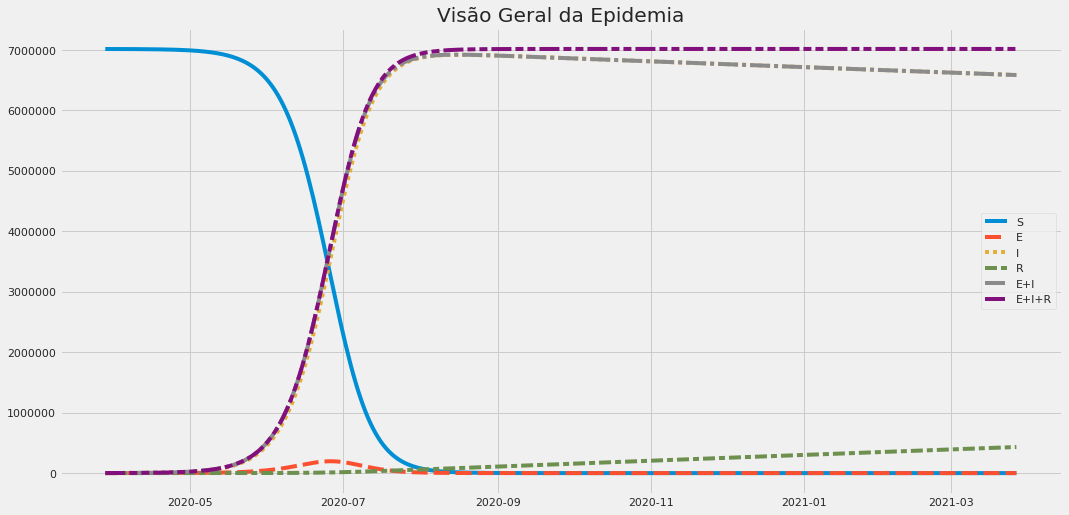

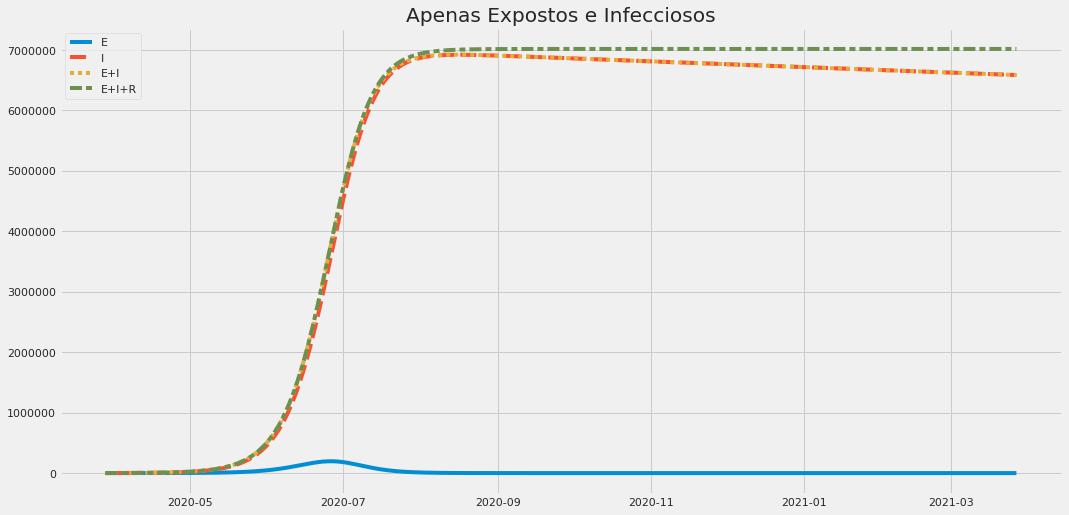

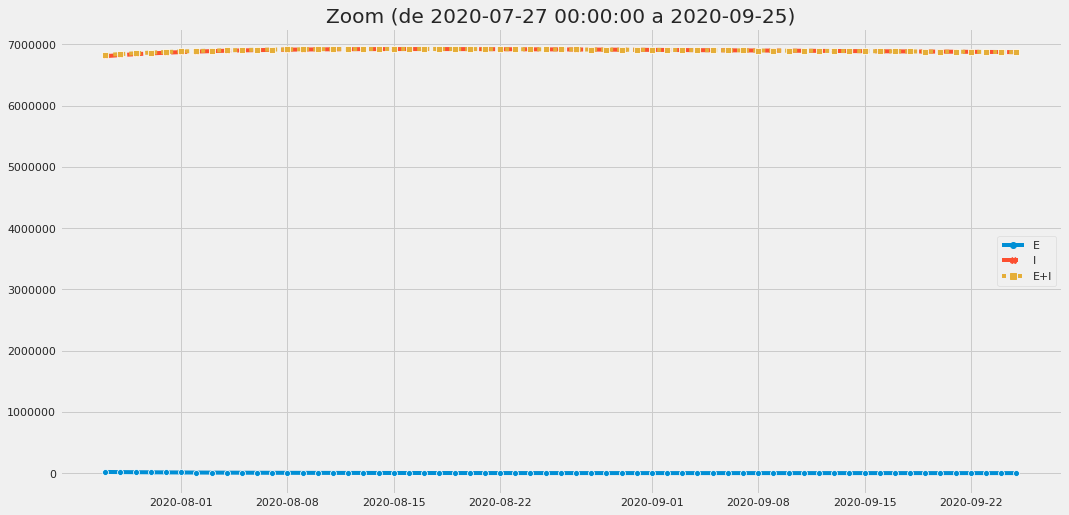

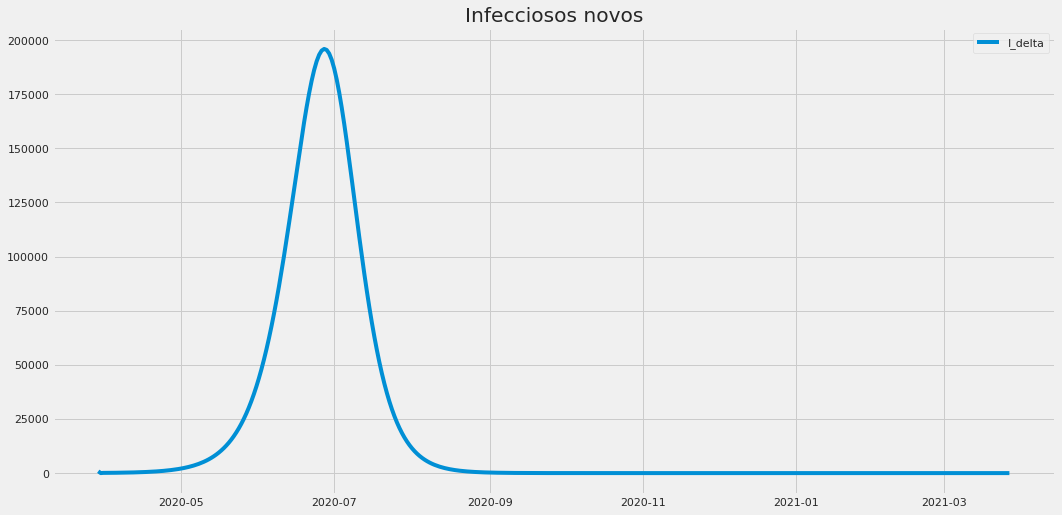

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,76,2,781,29,7018354.0,NaN,11715,NaN
2020-05-01,27,0,808,29,7018354.0,NaN,12120,NaN
2020-05-02,17,1,825,30,7018354.0,NaN,12375,NaN
2020-05-03,25,0,850,30,7018354.0,NaN,12750,NaN
2020-05-04,0,0,850,30,7018354.0,NaN,12750,NaN


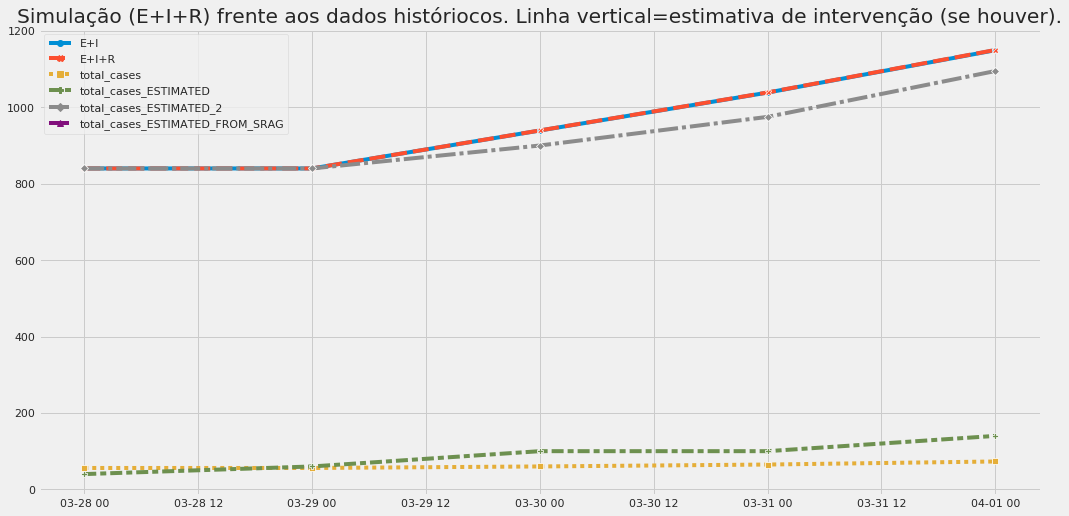

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 7/3000 [00:00<00:47, 63.67trial/s, best loss: 1202.6464719054939]

  0%|          | 15/3000 [00:00<00:45, 65.34trial/s, best loss: 1202.6464719054939]

  1%|          | 22/3000 [00:00<00:46, 64.14trial/s, best loss: 1202.6464719054939]

  1%|          | 27/3000 [00:00<00:55, 53.39trial/s, best loss: 1202.6464719054939]

  1%|          | 32/3000 [00:00<01:04, 46.13trial/s, best loss: 1202.6464719054939]

  1%|          | 36/3000 [00:00<01:07, 43.83trial/s, best loss: 1202.6464719054939]

  1%|▏         | 40/3000 [00:00<01:14, 39.64trial/s, best loss: 1202.6464719054939]

  1%|▏         | 44/3000 [00:01<01:33, 31.56trial/s, best loss: 1202.6464719054939]

  2%|▏         | 48/3000 [00:01<01:39, 29.57trial/s, best loss: 1202.6464719054939]

  2%|▏         | 52/3000 [00:01<01:43, 28.49trial/s, best loss: 1202.6464719054939]

  2%|▏         | 55/3000 [00:01<01:47, 27.50trial/s, best loss: 844.008391962541]  

  2%|▏         | 59/3000 [00:01<01:41, 28.92trial/s, best loss: 781.1605071275859]

  2%|▏         | 63/3000 [00:01<01:40, 29.34trial/s, best loss: 781.1605071275859]

  2%|▏         | 67/3000 [00:01<01:32, 31.57trial/s, best loss: 781.1605071275859]

  2%|▏         | 71/3000 [00:01<01:39, 29.47trial/s, best loss: 781.1605071275859]

  2%|▎         | 75/3000 [00:02<01:38, 29.58trial/s, best loss: 781.1605071275859]

  3%|▎         | 79/3000 [00:02<01:38, 29.67trial/s, best loss: 781.1605071275859]

  3%|▎         | 83/3000 [00:02<01:32, 31.70trial/s, best loss: 781.1605071275859]

  3%|▎         | 87/3000 [00:02<01:26, 33.58trial/s, best loss: 781.1605071275859]

  3%|▎         | 91/3000 [00:02<01:24, 34.40trial/s, best loss: 781.1605071275859]

  3%|▎         | 95/3000 [00:02<01:27, 33.25trial/s, best loss: 781.1605071275859]

  3%|▎         | 99/3000 [00:02<01:24, 34.25trial/s, best loss: 781.1605071275859]

  3%|▎         | 103/3000 [00:02<01:22, 35.00trial/s, best loss: 781.1605071275859]

  4%|▎         | 107/3000 [00:03<01:22, 35.06trial/s, best loss: 781.1605071275859]

  4%|▎         | 111/3000 [00:03<01:31, 31.71trial/s, best loss: 781.1605071275859]

  4%|▍         | 115/3000 [00:03<01:25, 33.56trial/s, best loss: 781.1605071275859]

  4%|▍         | 120/3000 [00:03<01:21, 35.29trial/s, best loss: 781.1605071275859]

  4%|▍         | 125/3000 [00:03<01:17, 36.89trial/s, best loss: 781.1605071275859]

  4%|▍         | 129/3000 [00:03<01:23, 34.31trial/s, best loss: 781.1605071275859]

  4%|▍         | 133/3000 [00:03<01:21, 35.20trial/s, best loss: 781.1605071275859]

  5%|▍         | 137/3000 [00:03<01:21, 35.25trial/s, best loss: 652.0204361874461]

  5%|▍         | 141/3000 [00:03<01:18, 36.48trial/s, best loss: 629.6091548680024]

  5%|▍         | 146/3000 [00:04<01:16, 37.41trial/s, best loss: 629.6091548680024]

  5%|▌         | 150/3000 [00:04<01:16, 37.30trial/s, best loss: 629.6091548680024]

  5%|▌         | 154/3000 [00:04<01:14, 37.96trial/s, best loss: 629.6091548680024]

  5%|▌         | 159/3000 [00:04<01:13, 38.39trial/s, best loss: 586.4018578403815]

  5%|▌         | 163/3000 [00:04<01:15, 37.41trial/s, best loss: 586.4018578403815]

  6%|▌         | 167/3000 [00:04<01:20, 35.29trial/s, best loss: 586.4018578403815]

  6%|▌         | 171/3000 [00:04<01:18, 35.84trial/s, best loss: 586.4018578403815]

  6%|▌         | 175/3000 [00:04<01:18, 36.20trial/s, best loss: 586.4018578403815]

  6%|▌         | 179/3000 [00:04<01:15, 37.14trial/s, best loss: 586.4018578403815]

  6%|▌         | 183/3000 [00:05<01:15, 37.45trial/s, best loss: 586.4018578403815]

  6%|▌         | 187/3000 [00:05<01:15, 37.46trial/s, best loss: 586.4018578403815]

  6%|▋         | 191/3000 [00:05<01:13, 37.99trial/s, best loss: 586.4018578403815]

  6%|▋         | 195/3000 [00:05<01:12, 38.44trial/s, best loss: 586.4018578403815]

  7%|▋         | 199/3000 [00:05<01:14, 37.66trial/s, best loss: 586.4018578403815]

  7%|▋         | 203/3000 [00:05<01:15, 36.97trial/s, best loss: 586.4018578403815]

  7%|▋         | 207/3000 [00:05<01:30, 31.00trial/s, best loss: 586.4018578403815]

  7%|▋         | 211/3000 [00:05<01:27, 31.91trial/s, best loss: 586.4018578403815]

  7%|▋         | 215/3000 [00:06<01:23, 33.29trial/s, best loss: 586.4018578403815]

  7%|▋         | 219/3000 [00:06<01:24, 32.75trial/s, best loss: 586.4018578403815]

  7%|▋         | 223/3000 [00:06<01:21, 34.05trial/s, best loss: 586.4018578403815]

  8%|▊         | 227/3000 [00:06<01:18, 35.24trial/s, best loss: 586.4018578403815]

  8%|▊         | 231/3000 [00:06<01:17, 35.86trial/s, best loss: 586.4018578403815]

  8%|▊         | 235/3000 [00:06<01:19, 34.94trial/s, best loss: 586.4018578403815]

  8%|▊         | 239/3000 [00:06<01:18, 35.01trial/s, best loss: 586.4018578403815]

  8%|▊         | 243/3000 [00:06<01:21, 34.01trial/s, best loss: 586.4018578403815]

  8%|▊         | 247/3000 [00:06<01:22, 33.47trial/s, best loss: 586.4018578403815]

  8%|▊         | 251/3000 [00:07<01:20, 34.12trial/s, best loss: 586.4018578403815]

  8%|▊         | 255/3000 [00:07<01:20, 34.27trial/s, best loss: 586.4018578403815]

  9%|▊         | 259/3000 [00:07<01:18, 35.11trial/s, best loss: 586.4018578403815]

  9%|▉         | 263/3000 [00:07<01:17, 35.32trial/s, best loss: 586.4018578403815]

  9%|▉         | 267/3000 [00:07<01:17, 35.37trial/s, best loss: 586.4018578403815]

  9%|▉         | 271/3000 [00:07<01:18, 34.63trial/s, best loss: 586.4018578403815]

  9%|▉         | 275/3000 [00:07<01:17, 35.21trial/s, best loss: 586.4018578403815]

  9%|▉         | 279/3000 [00:07<01:18, 34.81trial/s, best loss: 586.4018578403815]

  9%|▉         | 283/3000 [00:07<01:20, 33.81trial/s, best loss: 586.4018578403815]

 10%|▉         | 287/3000 [00:08<01:18, 34.62trial/s, best loss: 586.4018578403815]

 10%|▉         | 291/3000 [00:08<01:17, 35.09trial/s, best loss: 586.4018578403815]

 10%|▉         | 295/3000 [00:08<01:16, 35.18trial/s, best loss: 586.4018578403815]

 10%|▉         | 299/3000 [00:08<01:16, 35.32trial/s, best loss: 586.4018578403815]

 10%|█         | 303/3000 [00:08<01:17, 34.79trial/s, best loss: 586.4018578403815]

 10%|█         | 307/3000 [00:08<01:19, 33.73trial/s, best loss: 586.4018578403815]

 10%|█         | 311/3000 [00:08<01:26, 30.99trial/s, best loss: 586.4018578403815]

 10%|█         | 315/3000 [00:08<01:26, 30.93trial/s, best loss: 586.4018578403815]

 11%|█         | 319/3000 [00:09<01:26, 31.07trial/s, best loss: 566.6368005700004]

 11%|█         | 323/3000 [00:09<01:25, 31.25trial/s, best loss: 566.6368005700004]

 11%|█         | 327/3000 [00:09<01:25, 31.10trial/s, best loss: 566.6368005700004]

 11%|█         | 331/3000 [00:09<01:26, 30.81trial/s, best loss: 566.6368005700004]

 11%|█         | 335/3000 [00:09<01:32, 28.93trial/s, best loss: 566.6368005700004]

 11%|█▏        | 338/3000 [00:09<01:31, 29.13trial/s, best loss: 566.6368005700004]

 11%|█▏        | 341/3000 [00:09<01:31, 29.18trial/s, best loss: 566.6368005700004]

 11%|█▏        | 344/3000 [00:09<01:31, 29.04trial/s, best loss: 566.6368005700004]

 12%|█▏        | 347/3000 [00:10<01:45, 25.26trial/s, best loss: 566.6368005700004]

 12%|█▏        | 350/3000 [00:10<01:55, 22.87trial/s, best loss: 566.6368005700004]

 12%|█▏        | 353/3000 [00:10<01:52, 23.55trial/s, best loss: 566.6368005700004]

 12%|█▏        | 356/3000 [00:10<01:47, 24.51trial/s, best loss: 566.6368005700004]

 12%|█▏        | 359/3000 [00:10<01:44, 25.30trial/s, best loss: 566.6368005700004]

 12%|█▏        | 362/3000 [00:10<01:40, 26.18trial/s, best loss: 566.6368005700004]

 12%|█▏        | 365/3000 [00:10<01:37, 26.98trial/s, best loss: 566.6368005700004]

 12%|█▏        | 368/3000 [00:10<01:36, 27.21trial/s, best loss: 566.6368005700004]

 12%|█▏        | 371/3000 [00:11<01:35, 27.55trial/s, best loss: 566.6368005700004]

 12%|█▏        | 374/3000 [00:11<01:46, 24.55trial/s, best loss: 566.6368005700004]

 13%|█▎        | 377/3000 [00:11<01:43, 25.36trial/s, best loss: 566.6368005700004]

 13%|█▎        | 380/3000 [00:11<01:42, 25.58trial/s, best loss: 566.6368005700004]

 13%|█▎        | 383/3000 [00:11<01:43, 25.20trial/s, best loss: 566.6368005700004]

 13%|█▎        | 386/3000 [00:11<01:44, 25.04trial/s, best loss: 566.6368005700004]

 13%|█▎        | 389/3000 [00:11<01:50, 23.62trial/s, best loss: 566.6368005700004]

 13%|█▎        | 392/3000 [00:11<01:46, 24.57trial/s, best loss: 566.6368005700004]

 13%|█▎        | 395/3000 [00:12<01:44, 25.03trial/s, best loss: 566.6368005700004]

 13%|█▎        | 398/3000 [00:12<01:45, 24.73trial/s, best loss: 566.6368005700004]

 13%|█▎        | 401/3000 [00:12<01:49, 23.78trial/s, best loss: 566.6368005700004]

 13%|█▎        | 404/3000 [00:12<01:51, 23.30trial/s, best loss: 566.6368005700004]

 14%|█▎        | 407/3000 [00:12<01:47, 24.06trial/s, best loss: 566.6368005700004]

 14%|█▎        | 410/3000 [00:12<01:48, 23.83trial/s, best loss: 566.6368005700004]

 14%|█▍        | 413/3000 [00:12<01:45, 24.59trial/s, best loss: 566.6368005700004]

 14%|█▍        | 416/3000 [00:12<01:41, 25.49trial/s, best loss: 566.6368005700004]

 14%|█▍        | 419/3000 [00:12<01:39, 26.04trial/s, best loss: 566.6368005700004]

 14%|█▍        | 422/3000 [00:13<01:41, 25.45trial/s, best loss: 566.6368005700004]

 14%|█▍        | 425/3000 [00:13<01:40, 25.74trial/s, best loss: 566.6368005700004]

 14%|█▍        | 428/3000 [00:13<01:37, 26.50trial/s, best loss: 566.6368005700004]

 14%|█▍        | 431/3000 [00:13<01:34, 27.16trial/s, best loss: 566.6368005700004]

 14%|█▍        | 434/3000 [00:13<01:36, 26.45trial/s, best loss: 566.6368005700004]

 15%|█▍        | 437/3000 [00:13<01:50, 23.25trial/s, best loss: 566.6368005700004]

 15%|█▍        | 440/3000 [00:13<01:58, 21.67trial/s, best loss: 566.6368005700004]

 15%|█▍        | 443/3000 [00:14<01:57, 21.82trial/s, best loss: 566.6368005700004]

 15%|█▍        | 446/3000 [00:14<02:03, 20.60trial/s, best loss: 513.1229548035843]

 15%|█▍        | 449/3000 [00:14<01:56, 21.81trial/s, best loss: 513.1229548035843]

 15%|█▌        | 452/3000 [00:14<01:49, 23.28trial/s, best loss: 513.1229548035843]

 15%|█▌        | 455/3000 [00:14<01:44, 24.26trial/s, best loss: 513.1229548035843]

 15%|█▌        | 458/3000 [00:14<01:46, 23.85trial/s, best loss: 397.8399329796802]

 15%|█▌        | 461/3000 [00:14<01:50, 22.90trial/s, best loss: 397.8399329796802]

 15%|█▌        | 464/3000 [00:14<01:45, 24.12trial/s, best loss: 397.8399329796802]

 16%|█▌        | 467/3000 [00:15<01:42, 24.77trial/s, best loss: 397.8399329796802]

 16%|█▌        | 470/3000 [00:15<01:41, 24.98trial/s, best loss: 397.8399329796802]

 16%|█▌        | 473/3000 [00:15<01:41, 25.00trial/s, best loss: 397.8399329796802]

 16%|█▌        | 476/3000 [00:15<01:46, 23.77trial/s, best loss: 397.8399329796802]

 16%|█▌        | 479/3000 [00:15<01:47, 23.48trial/s, best loss: 397.8399329796802]

 16%|█▌        | 482/3000 [00:15<01:51, 22.64trial/s, best loss: 397.8399329796802]

 16%|█▌        | 485/3000 [00:15<01:55, 21.85trial/s, best loss: 397.8399329796802]

 16%|█▋        | 488/3000 [00:16<02:06, 19.84trial/s, best loss: 397.8399329796802]

 16%|█▋        | 491/3000 [00:16<01:59, 21.08trial/s, best loss: 397.8399329796802]

 16%|█▋        | 494/3000 [00:16<01:52, 22.30trial/s, best loss: 397.8399329796802]

 17%|█▋        | 497/3000 [00:16<01:48, 23.01trial/s, best loss: 397.8399329796802]

 17%|█▋        | 500/3000 [00:16<01:44, 23.82trial/s, best loss: 397.8399329796802]

 17%|█▋        | 503/3000 [00:16<01:48, 22.96trial/s, best loss: 397.8399329796802]

 17%|█▋        | 506/3000 [00:16<01:46, 23.41trial/s, best loss: 397.8399329796802]

 17%|█▋        | 509/3000 [00:16<01:45, 23.50trial/s, best loss: 397.8399329796802]

 17%|█▋        | 512/3000 [00:17<01:55, 21.62trial/s, best loss: 397.8399329796802]

 17%|█▋        | 515/3000 [00:17<01:49, 22.75trial/s, best loss: 397.8399329796802]

 17%|█▋        | 518/3000 [00:17<01:45, 23.57trial/s, best loss: 397.8399329796802]

 17%|█▋        | 521/3000 [00:17<01:43, 23.98trial/s, best loss: 397.8399329796802]

 17%|█▋        | 524/3000 [00:17<01:41, 24.49trial/s, best loss: 397.8399329796802]

 18%|█▊        | 527/3000 [00:17<01:43, 23.84trial/s, best loss: 397.8399329796802]

 18%|█▊        | 530/3000 [00:17<01:41, 24.40trial/s, best loss: 397.8399329796802]

 18%|█▊        | 533/3000 [00:17<01:48, 22.73trial/s, best loss: 397.8399329796802]

 18%|█▊        | 536/3000 [00:18<01:45, 23.26trial/s, best loss: 397.8399329796802]

 18%|█▊        | 539/3000 [00:18<01:43, 23.73trial/s, best loss: 397.8399329796802]

 18%|█▊        | 542/3000 [00:18<01:42, 24.04trial/s, best loss: 397.8399329796802]

 18%|█▊        | 545/3000 [00:18<01:52, 21.84trial/s, best loss: 397.8399329796802]

 18%|█▊        | 548/3000 [00:18<01:52, 21.76trial/s, best loss: 397.8399329796802]

 18%|█▊        | 551/3000 [00:18<01:49, 22.43trial/s, best loss: 397.8399329796802]

 18%|█▊        | 554/3000 [00:18<01:47, 22.81trial/s, best loss: 397.8399329796802]

 19%|█▊        | 557/3000 [00:18<01:44, 23.48trial/s, best loss: 397.8399329796802]

 19%|█▊        | 560/3000 [00:19<01:41, 24.04trial/s, best loss: 397.8399329796802]

 19%|█▉        | 563/3000 [00:19<01:41, 24.09trial/s, best loss: 397.8399329796802]

 19%|█▉        | 566/3000 [00:19<01:42, 23.75trial/s, best loss: 397.8399329796802]

 19%|█▉        | 569/3000 [00:19<01:39, 24.36trial/s, best loss: 397.8399329796802]

 19%|█▉        | 572/3000 [00:19<01:40, 24.26trial/s, best loss: 397.8399329796802]

 19%|█▉        | 575/3000 [00:19<01:41, 23.87trial/s, best loss: 397.8399329796802]

 19%|█▉        | 578/3000 [00:19<01:39, 24.35trial/s, best loss: 397.8399329796802]

 19%|█▉        | 581/3000 [00:19<01:38, 24.46trial/s, best loss: 397.8399329796802]

 19%|█▉        | 584/3000 [00:20<01:38, 24.50trial/s, best loss: 397.8399329796802]

 20%|█▉        | 587/3000 [00:20<01:37, 24.65trial/s, best loss: 397.8399329796802]

 20%|█▉        | 590/3000 [00:20<01:37, 24.69trial/s, best loss: 397.8399329796802]

 20%|█▉        | 593/3000 [00:20<01:38, 24.42trial/s, best loss: 397.8399329796802]

 20%|█▉        | 596/3000 [00:20<01:40, 24.00trial/s, best loss: 397.8399329796802]

 20%|█▉        | 599/3000 [00:20<01:43, 23.14trial/s, best loss: 397.8399329796802]

 20%|██        | 602/3000 [00:20<01:43, 23.11trial/s, best loss: 397.8399329796802]

 20%|██        | 605/3000 [00:20<01:43, 23.17trial/s, best loss: 397.8399329796802]

 20%|██        | 608/3000 [00:21<01:43, 23.03trial/s, best loss: 397.8399329796802]

 20%|██        | 611/3000 [00:21<01:41, 23.65trial/s, best loss: 397.8399329796802]

 20%|██        | 614/3000 [00:21<01:39, 24.08trial/s, best loss: 397.8399329796802]

 21%|██        | 617/3000 [00:21<01:37, 24.35trial/s, best loss: 397.8399329796802]

 21%|██        | 620/3000 [00:21<01:41, 23.56trial/s, best loss: 397.8399329796802]

 21%|██        | 623/3000 [00:21<01:41, 23.45trial/s, best loss: 397.8399329796802]

 21%|██        | 626/3000 [00:21<01:44, 22.62trial/s, best loss: 397.8399329796802]

 21%|██        | 629/3000 [00:21<01:44, 22.58trial/s, best loss: 397.8399329796802]

 21%|██        | 632/3000 [00:22<01:45, 22.39trial/s, best loss: 397.8399329796802]

 21%|██        | 635/3000 [00:22<01:45, 22.48trial/s, best loss: 397.8399329796802]

 21%|██▏       | 638/3000 [00:22<01:42, 23.00trial/s, best loss: 397.8399329796802]

 21%|██▏       | 641/3000 [00:22<01:43, 22.81trial/s, best loss: 397.8399329796802]

 21%|██▏       | 644/3000 [00:22<01:43, 22.67trial/s, best loss: 397.8399329796802]

 22%|██▏       | 647/3000 [00:22<01:42, 23.00trial/s, best loss: 397.8399329796802]

 22%|██▏       | 650/3000 [00:22<01:42, 22.89trial/s, best loss: 397.8399329796802]

 22%|██▏       | 653/3000 [00:23<01:41, 23.06trial/s, best loss: 397.8399329796802]

 22%|██▏       | 656/3000 [00:23<01:41, 23.01trial/s, best loss: 397.8399329796802]

 22%|██▏       | 659/3000 [00:23<01:39, 23.55trial/s, best loss: 397.8399329796802]

 22%|██▏       | 662/3000 [00:23<01:38, 23.70trial/s, best loss: 397.8399329796802]

 22%|██▏       | 665/3000 [00:23<01:39, 23.56trial/s, best loss: 397.8399329796802]

 22%|██▏       | 668/3000 [00:23<01:42, 22.68trial/s, best loss: 397.8399329796802]

 22%|██▏       | 671/3000 [00:23<01:45, 22.09trial/s, best loss: 397.8399329796802]

 22%|██▏       | 674/3000 [00:23<01:43, 22.47trial/s, best loss: 397.8399329796802]

 23%|██▎       | 677/3000 [00:24<01:42, 22.66trial/s, best loss: 397.8399329796802]

 23%|██▎       | 680/3000 [00:24<01:44, 22.12trial/s, best loss: 397.8399329796802]

 23%|██▎       | 683/3000 [00:24<01:44, 22.21trial/s, best loss: 397.8399329796802]

 23%|██▎       | 686/3000 [00:24<01:42, 22.57trial/s, best loss: 397.8399329796802]

 23%|██▎       | 689/3000 [00:24<01:47, 21.57trial/s, best loss: 397.8399329796802]

 23%|██▎       | 692/3000 [00:24<01:48, 21.23trial/s, best loss: 397.8399329796802]

 23%|██▎       | 695/3000 [00:24<01:47, 21.53trial/s, best loss: 397.8399329796802]

 23%|██▎       | 698/3000 [00:25<01:47, 21.43trial/s, best loss: 397.8399329796802]

 23%|██▎       | 701/3000 [00:25<01:44, 21.90trial/s, best loss: 397.8399329796802]

 23%|██▎       | 704/3000 [00:25<01:44, 21.97trial/s, best loss: 397.8399329796802]

 24%|██▎       | 707/3000 [00:25<01:54, 19.98trial/s, best loss: 397.8399329796802]

 24%|██▎       | 710/3000 [00:25<01:52, 20.27trial/s, best loss: 397.8399329796802]

 24%|██▍       | 713/3000 [00:25<01:52, 20.28trial/s, best loss: 397.8399329796802]

 24%|██▍       | 716/3000 [00:25<01:49, 20.87trial/s, best loss: 397.8399329796802]

 24%|██▍       | 719/3000 [00:26<01:47, 21.18trial/s, best loss: 397.8399329796802]

 24%|██▍       | 722/3000 [00:26<01:47, 21.26trial/s, best loss: 397.8399329796802]

 24%|██▍       | 725/3000 [00:26<01:45, 21.48trial/s, best loss: 397.8399329796802]

 24%|██▍       | 728/3000 [00:26<01:44, 21.67trial/s, best loss: 397.8399329796802]

 24%|██▍       | 731/3000 [00:26<01:47, 21.05trial/s, best loss: 397.8399329796802]

 24%|██▍       | 734/3000 [00:26<01:47, 21.13trial/s, best loss: 397.8399329796802]

 25%|██▍       | 737/3000 [00:26<01:49, 20.64trial/s, best loss: 397.8399329796802]

 25%|██▍       | 740/3000 [00:27<01:47, 20.94trial/s, best loss: 397.8399329796802]

 25%|██▍       | 743/3000 [00:27<01:45, 21.49trial/s, best loss: 397.8399329796802]

 25%|██▍       | 746/3000 [00:27<01:44, 21.64trial/s, best loss: 397.8399329796802]

 25%|██▍       | 749/3000 [00:27<01:45, 21.30trial/s, best loss: 397.8399329796802]

 25%|██▌       | 752/3000 [00:27<01:57, 19.13trial/s, best loss: 397.8399329796802]

 25%|██▌       | 754/3000 [00:27<02:00, 18.59trial/s, best loss: 397.8399329796802]

 25%|██▌       | 756/3000 [00:27<02:06, 17.79trial/s, best loss: 397.8399329796802]

 25%|██▌       | 758/3000 [00:28<02:08, 17.43trial/s, best loss: 397.8399329796802]

 25%|██▌       | 760/3000 [00:28<02:07, 17.59trial/s, best loss: 397.8399329796802]

 25%|██▌       | 762/3000 [00:28<02:03, 18.08trial/s, best loss: 397.8399329796802]

 25%|██▌       | 764/3000 [00:28<02:08, 17.35trial/s, best loss: 397.8399329796802]

 26%|██▌       | 766/3000 [00:28<02:17, 16.28trial/s, best loss: 397.8399329796802]

 26%|██▌       | 768/3000 [00:28<02:31, 14.71trial/s, best loss: 397.8399329796802]

 26%|██▌       | 770/3000 [00:28<02:35, 14.30trial/s, best loss: 397.8399329796802]

 26%|██▌       | 772/3000 [00:28<02:34, 14.42trial/s, best loss: 397.8399329796802]

 26%|██▌       | 774/3000 [00:29<02:33, 14.55trial/s, best loss: 397.8399329796802]

 26%|██▌       | 776/3000 [00:29<02:21, 15.67trial/s, best loss: 397.8399329796802]

 26%|██▌       | 779/3000 [00:29<02:12, 16.75trial/s, best loss: 397.8399329796802]

 26%|██▌       | 782/3000 [00:29<02:04, 17.83trial/s, best loss: 397.8399329796802]

 26%|██▌       | 784/3000 [00:29<02:23, 15.40trial/s, best loss: 397.8399329796802]

 26%|██▌       | 786/3000 [00:29<02:14, 16.50trial/s, best loss: 397.8399329796802]

 26%|██▋       | 788/3000 [00:29<02:08, 17.21trial/s, best loss: 397.8399329796802]

 26%|██▋       | 791/3000 [00:30<02:03, 17.87trial/s, best loss: 397.8399329796802]

 26%|██▋       | 793/3000 [00:30<01:59, 18.46trial/s, best loss: 397.8399329796802]

 26%|██▋       | 795/3000 [00:30<02:02, 18.00trial/s, best loss: 397.8399329796802]

 27%|██▋       | 798/3000 [00:30<01:59, 18.40trial/s, best loss: 397.8399329796802]

 27%|██▋       | 801/3000 [00:30<01:54, 19.13trial/s, best loss: 397.8399329796802]

 27%|██▋       | 803/3000 [00:30<02:03, 17.75trial/s, best loss: 397.8399329796802]

 27%|██▋       | 805/3000 [00:30<02:15, 16.15trial/s, best loss: 397.8399329796802]

 27%|██▋       | 807/3000 [00:30<02:14, 16.30trial/s, best loss: 355.69481951825117]

 27%|██▋       | 809/3000 [00:31<02:12, 16.54trial/s, best loss: 355.69481951825117]

 27%|██▋       | 812/3000 [00:31<02:04, 17.56trial/s, best loss: 355.69481951825117]

 27%|██▋       | 814/3000 [00:31<02:09, 16.91trial/s, best loss: 355.69481951825117]

 27%|██▋       | 816/3000 [00:31<02:08, 16.97trial/s, best loss: 355.69481951825117]

 27%|██▋       | 818/3000 [00:31<02:09, 16.85trial/s, best loss: 355.69481951825117]

 27%|██▋       | 820/3000 [00:31<02:06, 17.29trial/s, best loss: 355.69481951825117]

 27%|██▋       | 822/3000 [00:31<02:01, 17.96trial/s, best loss: 355.69481951825117]

 27%|██▋       | 824/3000 [00:31<01:59, 18.14trial/s, best loss: 355.69481951825117]

 28%|██▊       | 826/3000 [00:31<01:57, 18.48trial/s, best loss: 355.69481951825117]

 28%|██▊       | 829/3000 [00:32<01:54, 18.97trial/s, best loss: 355.69481951825117]

 28%|██▊       | 831/3000 [00:32<01:53, 19.13trial/s, best loss: 355.69481951825117]

 28%|██▊       | 834/3000 [00:32<01:51, 19.49trial/s, best loss: 355.69481951825117]

 28%|██▊       | 836/3000 [00:32<01:53, 19.02trial/s, best loss: 355.69481951825117]

 28%|██▊       | 838/3000 [00:32<01:56, 18.61trial/s, best loss: 355.69481951825117]

 28%|██▊       | 841/3000 [00:32<01:53, 19.07trial/s, best loss: 355.69481951825117]

 28%|██▊       | 843/3000 [00:32<01:57, 18.34trial/s, best loss: 355.69481951825117]

 28%|██▊       | 845/3000 [00:32<01:57, 18.39trial/s, best loss: 355.69481951825117]

 28%|██▊       | 847/3000 [00:33<01:57, 18.27trial/s, best loss: 355.69481951825117]

 28%|██▊       | 849/3000 [00:33<01:54, 18.72trial/s, best loss: 355.69481951825117]

 28%|██▊       | 851/3000 [00:33<01:55, 18.68trial/s, best loss: 355.69481951825117]

 28%|██▊       | 853/3000 [00:33<02:09, 16.56trial/s, best loss: 355.69481951825117]

 28%|██▊       | 855/3000 [00:33<02:18, 15.43trial/s, best loss: 355.69481951825117]

 29%|██▊       | 857/3000 [00:33<02:12, 16.18trial/s, best loss: 355.69481951825117]

 29%|██▊       | 860/3000 [00:33<02:04, 17.20trial/s, best loss: 355.69481951825117]

 29%|██▉       | 863/3000 [00:34<01:58, 18.01trial/s, best loss: 355.69481951825117]

 29%|██▉       | 865/3000 [00:34<02:13, 15.99trial/s, best loss: 355.69481951825117]

 29%|██▉       | 867/3000 [00:34<02:06, 16.89trial/s, best loss: 355.69481951825117]

 29%|██▉       | 869/3000 [00:34<02:02, 17.33trial/s, best loss: 355.69481951825117]

 29%|██▉       | 871/3000 [00:34<02:10, 16.30trial/s, best loss: 355.69481951825117]

 29%|██▉       | 873/3000 [00:34<02:06, 16.77trial/s, best loss: 355.69481951825117]

 29%|██▉       | 875/3000 [00:34<02:05, 16.87trial/s, best loss: 355.69481951825117]

 29%|██▉       | 877/3000 [00:34<02:14, 15.79trial/s, best loss: 355.69481951825117]

 29%|██▉       | 879/3000 [00:35<02:07, 16.60trial/s, best loss: 355.69481951825117]

 29%|██▉       | 881/3000 [00:35<02:06, 16.79trial/s, best loss: 355.69481951825117]

 29%|██▉       | 883/3000 [00:35<02:04, 16.94trial/s, best loss: 355.69481951825117]

 30%|██▉       | 885/3000 [00:35<02:03, 17.12trial/s, best loss: 355.69481951825117]

 30%|██▉       | 887/3000 [00:35<01:59, 17.67trial/s, best loss: 355.69481951825117]

 30%|██▉       | 889/3000 [00:35<01:59, 17.60trial/s, best loss: 355.69481951825117]

 30%|██▉       | 891/3000 [00:35<01:57, 17.96trial/s, best loss: 355.69481951825117]

 30%|██▉       | 893/3000 [00:35<01:58, 17.80trial/s, best loss: 355.69481951825117]

 30%|██▉       | 895/3000 [00:35<02:05, 16.72trial/s, best loss: 355.69481951825117]

 30%|██▉       | 897/3000 [00:36<02:07, 16.48trial/s, best loss: 355.69481951825117]

 30%|██▉       | 899/3000 [00:36<02:07, 16.46trial/s, best loss: 355.69481951825117]

 30%|███       | 901/3000 [00:36<02:03, 16.99trial/s, best loss: 355.69481951825117]

 30%|███       | 903/3000 [00:36<02:07, 16.44trial/s, best loss: 355.69481951825117]

 30%|███       | 905/3000 [00:36<02:04, 16.77trial/s, best loss: 355.69481951825117]

 30%|███       | 907/3000 [00:36<02:04, 16.82trial/s, best loss: 355.69481951825117]

 30%|███       | 909/3000 [00:36<01:59, 17.43trial/s, best loss: 355.69481951825117]

 30%|███       | 911/3000 [00:36<02:03, 16.85trial/s, best loss: 355.69481951825117]

 30%|███       | 913/3000 [00:37<02:19, 14.96trial/s, best loss: 355.69481951825117]

 30%|███       | 915/3000 [00:37<02:10, 15.99trial/s, best loss: 355.69481951825117]

 31%|███       | 917/3000 [00:37<02:03, 16.87trial/s, best loss: 355.69481951825117]

 31%|███       | 919/3000 [00:37<02:03, 16.86trial/s, best loss: 355.69481951825117]

 31%|███       | 921/3000 [00:37<01:59, 17.37trial/s, best loss: 355.69481951825117]

 31%|███       | 923/3000 [00:37<01:58, 17.57trial/s, best loss: 355.69481951825117]

 31%|███       | 925/3000 [00:37<01:54, 18.05trial/s, best loss: 355.69481951825117]

 31%|███       | 927/3000 [00:37<01:55, 17.99trial/s, best loss: 355.69481951825117]

 31%|███       | 929/3000 [00:37<01:55, 17.90trial/s, best loss: 355.69481951825117]

 31%|███       | 931/3000 [00:38<01:54, 18.07trial/s, best loss: 355.69481951825117]

 31%|███       | 933/3000 [00:38<01:57, 17.57trial/s, best loss: 355.69481951825117]

 31%|███       | 935/3000 [00:38<02:01, 16.95trial/s, best loss: 355.69481951825117]

 31%|███       | 937/3000 [00:38<02:06, 16.35trial/s, best loss: 355.69481951825117]

 31%|███▏      | 939/3000 [00:38<02:03, 16.67trial/s, best loss: 355.69481951825117]

 31%|███▏      | 941/3000 [00:38<02:06, 16.26trial/s, best loss: 355.69481951825117]

 31%|███▏      | 943/3000 [00:38<02:06, 16.25trial/s, best loss: 355.69481951825117]

 32%|███▏      | 945/3000 [00:38<02:31, 13.59trial/s, best loss: 355.69481951825117]

 32%|███▏      | 947/3000 [00:39<02:22, 14.42trial/s, best loss: 355.69481951825117]

 32%|███▏      | 949/3000 [00:39<02:14, 15.29trial/s, best loss: 355.69481951825117]

 32%|███▏      | 951/3000 [00:39<02:12, 15.48trial/s, best loss: 355.69481951825117]

 32%|███▏      | 953/3000 [00:39<02:07, 16.02trial/s, best loss: 355.69481951825117]

 32%|███▏      | 955/3000 [00:39<02:15, 15.10trial/s, best loss: 335.5220136624571] 

 32%|███▏      | 957/3000 [00:39<02:09, 15.82trial/s, best loss: 335.5220136624571]

 32%|███▏      | 959/3000 [00:39<02:07, 15.97trial/s, best loss: 335.5220136624571]

 32%|███▏      | 961/3000 [00:39<02:06, 16.17trial/s, best loss: 335.5220136624571]

 32%|███▏      | 963/3000 [00:40<02:01, 16.81trial/s, best loss: 335.5220136624571]

 32%|███▏      | 965/3000 [00:40<01:59, 17.08trial/s, best loss: 335.5220136624571]

 32%|███▏      | 967/3000 [00:40<01:56, 17.42trial/s, best loss: 335.5220136624571]

 32%|███▏      | 969/3000 [00:40<01:54, 17.69trial/s, best loss: 335.5220136624571]

 32%|███▏      | 971/3000 [00:40<01:54, 17.80trial/s, best loss: 335.5220136624571]

 32%|███▏      | 973/3000 [00:40<01:53, 17.82trial/s, best loss: 335.5220136624571]

 32%|███▎      | 975/3000 [00:40<01:52, 18.03trial/s, best loss: 335.5220136624571]

 33%|███▎      | 977/3000 [00:40<01:51, 18.12trial/s, best loss: 335.5220136624571]

 33%|███▎      | 979/3000 [00:40<01:55, 17.50trial/s, best loss: 335.5220136624571]

 33%|███▎      | 981/3000 [00:41<01:59, 16.90trial/s, best loss: 335.5220136624571]

 33%|███▎      | 983/3000 [00:41<01:56, 17.31trial/s, best loss: 335.5220136624571]

 33%|███▎      | 985/3000 [00:41<01:54, 17.63trial/s, best loss: 335.5220136624571]

 33%|███▎      | 987/3000 [00:41<01:52, 17.97trial/s, best loss: 335.5220136624571]

 33%|███▎      | 989/3000 [00:41<01:53, 17.69trial/s, best loss: 335.5220136624571]

 33%|███▎      | 991/3000 [00:41<01:55, 17.45trial/s, best loss: 335.5220136624571]

 33%|███▎      | 993/3000 [00:41<01:58, 16.90trial/s, best loss: 335.5220136624571]

 33%|███▎      | 995/3000 [00:41<01:56, 17.15trial/s, best loss: 335.5220136624571]

 33%|███▎      | 997/3000 [00:41<01:54, 17.49trial/s, best loss: 335.5220136624571]

 33%|███▎      | 999/3000 [00:42<01:53, 17.70trial/s, best loss: 335.5220136624571]

 33%|███▎      | 1001/3000 [00:42<01:49, 18.25trial/s, best loss: 335.5220136624571]

 33%|███▎      | 1003/3000 [00:42<01:47, 18.53trial/s, best loss: 335.5220136624571]

 34%|███▎      | 1005/3000 [00:42<01:51, 17.90trial/s, best loss: 335.5220136624571]

 34%|███▎      | 1007/3000 [00:42<01:52, 17.74trial/s, best loss: 335.5220136624571]

 34%|███▎      | 1009/3000 [00:42<01:58, 16.76trial/s, best loss: 335.5220136624571]

 34%|███▎      | 1011/3000 [00:42<01:58, 16.75trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1013/3000 [00:42<01:56, 17.12trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1015/3000 [00:43<01:54, 17.30trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1017/3000 [00:43<01:53, 17.50trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1019/3000 [00:43<01:51, 17.70trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1021/3000 [00:43<01:50, 17.94trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1023/3000 [00:43<01:48, 18.15trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1025/3000 [00:43<01:54, 17.30trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1027/3000 [00:43<02:13, 14.77trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1029/3000 [00:43<02:09, 15.24trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1031/3000 [00:44<02:14, 14.63trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1033/3000 [00:44<02:12, 14.81trial/s, best loss: 335.5220136624571]

 34%|███▍      | 1035/3000 [00:44<02:05, 15.72trial/s, best loss: 335.5220136624571]

 35%|███▍      | 1037/3000 [00:44<02:00, 16.23trial/s, best loss: 335.5220136624571]

 35%|███▍      | 1039/3000 [00:44<01:55, 16.95trial/s, best loss: 335.5220136624571]

 35%|███▍      | 1041/3000 [00:44<01:57, 16.61trial/s, best loss: 335.5220136624571]

 35%|███▍      | 1043/3000 [00:44<01:56, 16.83trial/s, best loss: 335.5220136624571]

 35%|███▍      | 1045/3000 [00:44<01:54, 17.14trial/s, best loss: 335.5220136624571]

 35%|███▍      | 1047/3000 [00:44<01:50, 17.60trial/s, best loss: 335.5220136624571]

 35%|███▍      | 1049/3000 [00:45<01:51, 17.43trial/s, best loss: 335.5220136624571]

 35%|███▌      | 1051/3000 [00:45<02:11, 14.81trial/s, best loss: 335.5220136624571]

 35%|███▌      | 1053/3000 [00:45<02:20, 13.85trial/s, best loss: 335.5220136624571]

 35%|███▌      | 1055/3000 [00:45<02:10, 14.93trial/s, best loss: 335.5220136624571]

 35%|███▌      | 1057/3000 [00:45<02:08, 15.17trial/s, best loss: 335.5220136624571]

 35%|███▌      | 1059/3000 [00:45<02:04, 15.54trial/s, best loss: 335.5220136624571]

 35%|███▌      | 1061/3000 [00:45<02:01, 15.90trial/s, best loss: 335.5220136624571]

 35%|███▌      | 1063/3000 [00:46<01:56, 16.64trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1065/3000 [00:46<01:56, 16.68trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1067/3000 [00:46<02:02, 15.78trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1069/3000 [00:46<01:59, 16.14trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1071/3000 [00:46<01:57, 16.39trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1073/3000 [00:46<01:58, 16.25trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1075/3000 [00:46<01:54, 16.76trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1077/3000 [00:46<01:54, 16.84trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1079/3000 [00:46<01:53, 16.86trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1081/3000 [00:47<01:53, 16.94trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1083/3000 [00:47<01:54, 16.72trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1085/3000 [00:47<02:04, 15.35trial/s, best loss: 335.5220136624571]

 36%|███▌      | 1087/3000 [00:47<01:59, 15.97trial/s, best loss: 335.5220136624571]

 36%|███▋      | 1089/3000 [00:47<02:02, 15.64trial/s, best loss: 335.5220136624571]

 36%|███▋      | 1091/3000 [00:47<02:00, 15.78trial/s, best loss: 335.5220136624571]

 36%|███▋      | 1093/3000 [00:47<02:03, 15.39trial/s, best loss: 335.5220136624571]

 36%|███▋      | 1095/3000 [00:48<02:01, 15.65trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1097/3000 [00:48<01:58, 15.99trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1099/3000 [00:48<02:02, 15.52trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1101/3000 [00:48<02:00, 15.81trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1103/3000 [00:48<01:58, 16.03trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1105/3000 [00:48<01:57, 16.09trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1107/3000 [00:48<01:56, 16.22trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1109/3000 [00:48<01:56, 16.23trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1111/3000 [00:49<02:10, 14.53trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1113/3000 [00:49<02:04, 15.21trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1115/3000 [00:49<01:58, 15.90trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1117/3000 [00:49<01:54, 16.46trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1119/3000 [00:49<01:53, 16.61trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1121/3000 [00:49<01:57, 15.97trial/s, best loss: 335.5220136624571]

 37%|███▋      | 1123/3000 [00:49<01:54, 16.37trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1125/3000 [00:49<01:53, 16.47trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1127/3000 [00:49<01:53, 16.52trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1129/3000 [00:50<01:51, 16.80trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1131/3000 [00:50<01:51, 16.78trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1133/3000 [00:50<01:50, 16.90trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1135/3000 [00:50<01:50, 16.82trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1137/3000 [00:50<01:51, 16.71trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1139/3000 [00:50<01:50, 16.88trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1141/3000 [00:50<01:49, 16.94trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1143/3000 [00:50<01:51, 16.71trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1145/3000 [00:51<01:51, 16.66trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1147/3000 [00:51<01:50, 16.74trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1149/3000 [00:51<01:51, 16.64trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1151/3000 [00:51<01:51, 16.58trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1153/3000 [00:51<02:02, 15.05trial/s, best loss: 335.5220136624571]

 38%|███▊      | 1155/3000 [00:51<02:11, 14.04trial/s, best loss: 335.5220136624571]

 39%|███▊      | 1157/3000 [00:51<02:06, 14.51trial/s, best loss: 335.5220136624571]

 39%|███▊      | 1159/3000 [00:51<02:02, 14.99trial/s, best loss: 335.5220136624571]

 39%|███▊      | 1161/3000 [00:52<01:58, 15.48trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1163/3000 [00:52<01:56, 15.71trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1165/3000 [00:52<01:53, 16.15trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1167/3000 [00:52<01:50, 16.54trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1169/3000 [00:52<01:52, 16.32trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1171/3000 [00:52<01:56, 15.65trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1173/3000 [00:52<01:52, 16.23trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1175/3000 [00:52<01:51, 16.38trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1177/3000 [00:53<01:49, 16.61trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1179/3000 [00:53<01:48, 16.81trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1181/3000 [00:53<01:47, 16.89trial/s, best loss: 335.5220136624571]

 39%|███▉      | 1183/3000 [00:53<01:47, 16.96trial/s, best loss: 335.5220136624571]

 40%|███▉      | 1185/3000 [00:53<01:52, 16.11trial/s, best loss: 335.5220136624571]

 40%|███▉      | 1187/3000 [00:53<01:54, 15.87trial/s, best loss: 335.5220136624571]

 40%|███▉      | 1189/3000 [00:53<01:56, 15.61trial/s, best loss: 335.5220136624571]

 40%|███▉      | 1191/3000 [00:53<01:54, 15.76trial/s, best loss: 335.5220136624571]

 40%|███▉      | 1193/3000 [00:54<01:51, 16.17trial/s, best loss: 335.5220136624571]

 40%|███▉      | 1195/3000 [00:54<01:52, 16.02trial/s, best loss: 335.5220136624571]

 40%|███▉      | 1197/3000 [00:54<01:51, 16.11trial/s, best loss: 335.5220136624571]

 40%|███▉      | 1199/3000 [00:54<01:51, 16.15trial/s, best loss: 335.5220136624571]

 40%|████      | 1201/3000 [00:54<01:50, 16.26trial/s, best loss: 335.5220136624571]

 40%|████      | 1203/3000 [00:54<01:50, 16.22trial/s, best loss: 335.5220136624571]

 40%|████      | 1205/3000 [00:54<01:49, 16.47trial/s, best loss: 335.5220136624571]

 40%|████      | 1207/3000 [00:54<01:50, 16.20trial/s, best loss: 335.5220136624571]

 40%|████      | 1209/3000 [00:55<01:50, 16.27trial/s, best loss: 335.5220136624571]

 40%|████      | 1211/3000 [00:55<01:49, 16.28trial/s, best loss: 335.5220136624571]

 40%|████      | 1213/3000 [00:55<01:49, 16.38trial/s, best loss: 335.5220136624571]

 40%|████      | 1215/3000 [00:55<01:48, 16.40trial/s, best loss: 335.5220136624571]

 41%|████      | 1217/3000 [00:55<01:48, 16.41trial/s, best loss: 335.5220136624571]

 41%|████      | 1219/3000 [00:55<01:52, 15.82trial/s, best loss: 335.5220136624571]

 41%|████      | 1221/3000 [00:55<01:50, 16.03trial/s, best loss: 335.5220136624571]

 41%|████      | 1223/3000 [00:55<01:52, 15.85trial/s, best loss: 335.5220136624571]

 41%|████      | 1225/3000 [00:56<01:49, 16.17trial/s, best loss: 335.5220136624571]

 41%|████      | 1227/3000 [00:56<01:47, 16.46trial/s, best loss: 335.5220136624571]

 41%|████      | 1229/3000 [00:56<01:46, 16.67trial/s, best loss: 335.5220136624571]

 41%|████      | 1231/3000 [00:56<01:47, 16.43trial/s, best loss: 335.5220136624571]

 41%|████      | 1233/3000 [00:56<01:46, 16.58trial/s, best loss: 335.5220136624571]

 41%|████      | 1235/3000 [00:56<01:51, 15.77trial/s, best loss: 335.5220136624571]

 41%|████      | 1237/3000 [00:56<01:52, 15.61trial/s, best loss: 335.5220136624571]

 41%|████▏     | 1239/3000 [00:56<01:53, 15.55trial/s, best loss: 335.5220136624571]

 41%|████▏     | 1241/3000 [00:57<01:58, 14.82trial/s, best loss: 335.5220136624571]

 41%|████▏     | 1243/3000 [00:57<01:57, 14.90trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1245/3000 [00:57<01:57, 14.98trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1247/3000 [00:57<01:56, 15.07trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1249/3000 [00:57<01:58, 14.81trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1251/3000 [00:57<01:56, 14.98trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1253/3000 [00:57<01:56, 14.95trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1255/3000 [00:58<01:55, 15.15trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1257/3000 [00:58<02:10, 13.33trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1259/3000 [00:58<02:07, 13.65trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1261/3000 [00:58<02:03, 14.09trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1263/3000 [00:58<02:04, 14.00trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1265/3000 [00:58<02:05, 13.84trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1267/3000 [00:58<02:03, 14.00trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1269/3000 [00:59<02:01, 14.23trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1271/3000 [00:59<02:06, 13.69trial/s, best loss: 335.5220136624571]

 42%|████▏     | 1273/3000 [00:59<01:59, 14.50trial/s, best loss: 335.5220136624571]

 42%|████▎     | 1275/3000 [00:59<01:54, 15.02trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1277/3000 [00:59<01:54, 15.10trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1279/3000 [00:59<01:52, 15.30trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1281/3000 [00:59<01:51, 15.39trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1283/3000 [00:59<01:53, 15.17trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1285/3000 [01:00<01:51, 15.35trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1287/3000 [01:00<01:50, 15.47trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1289/3000 [01:00<01:54, 14.88trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1291/3000 [01:00<01:56, 14.68trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1293/3000 [01:00<02:00, 14.20trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1295/3000 [01:00<01:59, 14.31trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1297/3000 [01:00<01:57, 14.53trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1299/3000 [01:01<01:55, 14.77trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1301/3000 [01:01<01:55, 14.73trial/s, best loss: 335.5220136624571]

 43%|████▎     | 1303/3000 [01:01<01:54, 14.83trial/s, best loss: 335.5220136624571]

 44%|████▎     | 1305/3000 [01:01<01:54, 14.78trial/s, best loss: 335.5220136624571]

 44%|████▎     | 1307/3000 [01:01<02:20, 12.06trial/s, best loss: 335.5220136624571]

 44%|████▎     | 1309/3000 [01:01<02:22, 11.83trial/s, best loss: 335.5220136624571]

 44%|████▎     | 1311/3000 [01:02<02:18, 12.20trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1313/3000 [01:02<02:15, 12.46trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1315/3000 [01:02<02:20, 12.00trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1317/3000 [01:02<02:55,  9.60trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1319/3000 [01:02<02:49,  9.92trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1321/3000 [01:03<02:48,  9.95trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1323/3000 [01:03<02:38, 10.56trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1325/3000 [01:03<02:26, 11.41trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1327/3000 [01:03<02:15, 12.36trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1329/3000 [01:03<02:20, 11.89trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1331/3000 [01:03<02:28, 11.24trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1333/3000 [01:04<02:30, 11.10trial/s, best loss: 335.5220136624571]

 44%|████▍     | 1335/3000 [01:04<02:20, 11.88trial/s, best loss: 335.5220136624571]

 45%|████▍     | 1337/3000 [01:04<02:08, 12.91trial/s, best loss: 335.5220136624571]

 45%|████▍     | 1339/3000 [01:04<01:59, 13.85trial/s, best loss: 335.5220136624571]

 45%|████▍     | 1341/3000 [01:04<02:04, 13.28trial/s, best loss: 335.5220136624571]

 45%|████▍     | 1343/3000 [01:04<02:07, 13.04trial/s, best loss: 335.5220136624571]

 45%|████▍     | 1345/3000 [01:04<02:10, 12.69trial/s, best loss: 335.5220136624571]

 45%|████▍     | 1347/3000 [01:05<02:04, 13.31trial/s, best loss: 335.5220136624571]

 45%|████▍     | 1349/3000 [01:05<02:07, 12.92trial/s, best loss: 335.5220136624571]

 45%|████▌     | 1351/3000 [01:05<02:01, 13.56trial/s, best loss: 335.5220136624571]

 45%|████▌     | 1353/3000 [01:05<02:04, 13.26trial/s, best loss: 335.5220136624571]

 45%|████▌     | 1355/3000 [01:05<02:04, 13.17trial/s, best loss: 335.5220136624571]

 45%|████▌     | 1357/3000 [01:05<01:57, 14.02trial/s, best loss: 335.5220136624571]

 45%|████▌     | 1359/3000 [01:05<01:53, 14.48trial/s, best loss: 335.5220136624571]

 45%|████▌     | 1361/3000 [01:06<01:48, 15.13trial/s, best loss: 335.5220136624571]

 45%|████▌     | 1363/3000 [01:06<01:45, 15.59trial/s, best loss: 335.5220136624571]

 46%|████▌     | 1365/3000 [01:06<01:44, 15.59trial/s, best loss: 335.5220136624571]

 46%|████▌     | 1367/3000 [01:06<01:46, 15.39trial/s, best loss: 335.5220136624571]

 46%|████▌     | 1369/3000 [01:06<01:51, 14.57trial/s, best loss: 335.5220136624571]

 46%|████▌     | 1371/3000 [01:06<01:52, 14.51trial/s, best loss: 335.5220136624571]

 46%|████▌     | 1373/3000 [01:06<01:54, 14.21trial/s, best loss: 335.5220136624571]

 46%|████▌     | 1375/3000 [01:06<01:52, 14.38trial/s, best loss: 335.5220136624571]

 46%|████▌     | 1377/3000 [01:07<01:50, 14.66trial/s, best loss: 321.25252818682503]

 46%|████▌     | 1379/3000 [01:07<02:03, 13.17trial/s, best loss: 321.25252818682503]

 46%|████▌     | 1381/3000 [01:07<02:00, 13.43trial/s, best loss: 321.25252818682503]

 46%|████▌     | 1383/3000 [01:07<02:00, 13.45trial/s, best loss: 321.25252818682503]

 46%|████▌     | 1385/3000 [01:07<01:55, 14.01trial/s, best loss: 321.25252818682503]

 46%|████▌     | 1387/3000 [01:07<01:56, 13.82trial/s, best loss: 321.25252818682503]

 46%|████▋     | 1389/3000 [01:08<01:55, 14.00trial/s, best loss: 321.25252818682503]

 46%|████▋     | 1391/3000 [01:08<02:00, 13.35trial/s, best loss: 321.25252818682503]

 46%|████▋     | 1393/3000 [01:08<01:56, 13.74trial/s, best loss: 321.25252818682503]

 46%|████▋     | 1395/3000 [01:08<02:00, 13.29trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1397/3000 [01:08<01:59, 13.46trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1399/3000 [01:08<02:06, 12.61trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1401/3000 [01:09<02:15, 11.84trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1403/3000 [01:09<02:27, 10.85trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1405/3000 [01:09<02:13, 11.91trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1407/3000 [01:09<02:05, 12.65trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1409/3000 [01:09<02:09, 12.26trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1411/3000 [01:09<02:07, 12.49trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1413/3000 [01:09<02:09, 12.27trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1415/3000 [01:10<02:09, 12.26trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1417/3000 [01:10<02:11, 12.07trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1419/3000 [01:10<02:16, 11.61trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1421/3000 [01:10<02:30, 10.47trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1423/3000 [01:10<02:43,  9.63trial/s, best loss: 321.25252818682503]

 47%|████▋     | 1424/3000 [01:11<02:45,  9.52trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1425/3000 [01:11<02:47,  9.40trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1426/3000 [01:11<02:45,  9.53trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1428/3000 [01:11<02:40,  9.81trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1430/3000 [01:11<02:32, 10.30trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1432/3000 [01:11<02:21, 11.10trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1434/3000 [01:11<02:19, 11.22trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1436/3000 [01:12<02:22, 11.01trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1438/3000 [01:12<02:15, 11.50trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1440/3000 [01:12<02:14, 11.59trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1442/3000 [01:12<02:22, 10.90trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1444/3000 [01:12<02:20, 11.06trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1446/3000 [01:13<02:27, 10.52trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1448/3000 [01:13<02:22, 10.93trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1450/3000 [01:13<02:23, 10.81trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1452/3000 [01:13<02:27, 10.49trial/s, best loss: 321.25252818682503]

 48%|████▊     | 1454/3000 [01:13<02:25, 10.64trial/s, best loss: 321.25252818682503]

 49%|████▊     | 1456/3000 [01:14<02:35,  9.95trial/s, best loss: 321.25252818682503]

 49%|████▊     | 1458/3000 [01:14<02:36,  9.88trial/s, best loss: 321.25252818682503]

 49%|████▊     | 1460/3000 [01:14<02:27, 10.41trial/s, best loss: 321.25252818682503]

 49%|████▊     | 1462/3000 [01:14<02:33, 10.01trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1464/3000 [01:14<02:33,  9.98trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1466/3000 [01:15<02:31, 10.16trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1468/3000 [01:15<02:29, 10.23trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1470/3000 [01:15<02:35,  9.87trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1472/3000 [01:15<02:25, 10.52trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1474/3000 [01:15<02:24, 10.55trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1476/3000 [01:16<02:33,  9.93trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1478/3000 [01:16<02:26, 10.41trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1480/3000 [01:16<02:24, 10.54trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1482/3000 [01:16<02:17, 11.04trial/s, best loss: 321.25252818682503]

 49%|████▉     | 1484/3000 [01:16<02:16, 11.11trial/s, best loss: 321.25252818682503]

 50%|████▉     | 1486/3000 [01:16<02:14, 11.25trial/s, best loss: 321.25252818682503]

 50%|████▉     | 1488/3000 [01:17<02:43,  9.26trial/s, best loss: 321.25252818682503]

 50%|████▉     | 1490/3000 [01:17<02:34,  9.78trial/s, best loss: 321.25252818682503]

 50%|████▉     | 1492/3000 [01:17<02:29, 10.06trial/s, best loss: 321.25252818682503]

 50%|████▉     | 1494/3000 [01:17<02:15, 11.09trial/s, best loss: 321.25252818682503]

 50%|████▉     | 1496/3000 [01:17<02:11, 11.40trial/s, best loss: 321.25252818682503]

 50%|████▉     | 1498/3000 [01:18<02:16, 11.00trial/s, best loss: 321.25252818682503]

 50%|█████     | 1500/3000 [01:18<02:22, 10.50trial/s, best loss: 321.25252818682503]

 50%|█████     | 1502/3000 [01:18<02:22, 10.48trial/s, best loss: 321.25252818682503]

 50%|█████     | 1504/3000 [01:18<02:26, 10.18trial/s, best loss: 321.25252818682503]

 50%|█████     | 1506/3000 [01:18<02:18, 10.80trial/s, best loss: 321.25252818682503]

 50%|█████     | 1508/3000 [01:19<02:21, 10.54trial/s, best loss: 321.25252818682503]

 50%|█████     | 1510/3000 [01:19<02:17, 10.86trial/s, best loss: 321.25252818682503]

 50%|█████     | 1512/3000 [01:19<02:09, 11.52trial/s, best loss: 321.25252818682503]

 50%|█████     | 1514/3000 [01:19<02:02, 12.08trial/s, best loss: 321.25252818682503]

 51%|█████     | 1516/3000 [01:19<02:02, 12.08trial/s, best loss: 321.25252818682503]

 51%|█████     | 1518/3000 [01:19<01:59, 12.38trial/s, best loss: 321.25252818682503]

 51%|█████     | 1520/3000 [01:19<01:59, 12.42trial/s, best loss: 321.25252818682503]

 51%|█████     | 1522/3000 [01:20<01:55, 12.84trial/s, best loss: 321.25252818682503]

 51%|█████     | 1524/3000 [01:20<01:50, 13.34trial/s, best loss: 321.25252818682503]

 51%|█████     | 1526/3000 [01:20<01:47, 13.74trial/s, best loss: 321.25252818682503]

 51%|█████     | 1528/3000 [01:20<01:47, 13.64trial/s, best loss: 321.25252818682503]

 51%|█████     | 1530/3000 [01:20<01:50, 13.28trial/s, best loss: 321.25252818682503]

 51%|█████     | 1532/3000 [01:21<02:24, 10.13trial/s, best loss: 321.25252818682503]

 51%|█████     | 1534/3000 [01:21<02:16, 10.72trial/s, best loss: 321.25252818682503]

 51%|█████     | 1536/3000 [01:21<02:07, 11.45trial/s, best loss: 321.25252818682503]

 51%|█████▏    | 1538/3000 [01:21<01:56, 12.55trial/s, best loss: 321.25252818682503]

 51%|█████▏    | 1540/3000 [01:21<01:51, 13.07trial/s, best loss: 321.25252818682503]

 51%|█████▏    | 1542/3000 [01:21<01:45, 13.84trial/s, best loss: 321.25252818682503]

 51%|█████▏    | 1544/3000 [01:21<01:40, 14.46trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1546/3000 [01:21<01:38, 14.76trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1548/3000 [01:22<01:36, 15.07trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1550/3000 [01:22<01:35, 15.13trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1552/3000 [01:22<01:36, 14.95trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1554/3000 [01:22<01:37, 14.79trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1556/3000 [01:22<01:43, 13.95trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1558/3000 [01:22<01:44, 13.76trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1560/3000 [01:22<01:43, 13.90trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1562/3000 [01:23<01:41, 14.18trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1564/3000 [01:23<01:37, 14.78trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1566/3000 [01:23<01:34, 15.11trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1568/3000 [01:23<01:33, 15.38trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1570/3000 [01:23<01:33, 15.24trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1572/3000 [01:23<01:32, 15.48trial/s, best loss: 321.25252818682503]

 52%|█████▏    | 1574/3000 [01:23<01:43, 13.71trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1576/3000 [01:24<01:39, 14.32trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1578/3000 [01:24<01:38, 14.45trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1580/3000 [01:24<01:34, 14.96trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1582/3000 [01:24<01:34, 15.00trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1584/3000 [01:24<01:34, 14.95trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1586/3000 [01:24<01:32, 15.24trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1588/3000 [01:24<01:30, 15.54trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1590/3000 [01:24<01:29, 15.75trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1592/3000 [01:25<01:28, 15.90trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1594/3000 [01:25<01:27, 16.08trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1596/3000 [01:25<01:26, 16.17trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1598/3000 [01:25<01:26, 16.16trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1600/3000 [01:25<01:27, 16.02trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1602/3000 [01:25<01:30, 15.38trial/s, best loss: 321.25252818682503]

 53%|█████▎    | 1604/3000 [01:25<01:30, 15.37trial/s, best loss: 321.25252818682503]

 54%|█████▎    | 1606/3000 [01:25<01:30, 15.44trial/s, best loss: 321.25252818682503]

 54%|█████▎    | 1608/3000 [01:26<01:28, 15.64trial/s, best loss: 321.25252818682503]

 54%|█████▎    | 1610/3000 [01:26<01:27, 15.89trial/s, best loss: 321.25252818682503]

 54%|█████▎    | 1612/3000 [01:26<01:26, 16.04trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1614/3000 [01:26<01:26, 16.05trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1616/3000 [01:26<01:28, 15.65trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1618/3000 [01:26<01:38, 14.10trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1620/3000 [01:26<01:33, 14.73trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1622/3000 [01:26<01:30, 15.15trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1624/3000 [01:27<01:29, 15.42trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1626/3000 [01:27<01:28, 15.57trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1628/3000 [01:27<01:29, 15.35trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1630/3000 [01:27<01:28, 15.56trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1632/3000 [01:27<01:28, 15.47trial/s, best loss: 321.25252818682503]

 54%|█████▍    | 1634/3000 [01:27<01:27, 15.65trial/s, best loss: 321.25252818682503]

 55%|█████▍    | 1636/3000 [01:27<01:26, 15.72trial/s, best loss: 321.25252818682503]

 55%|█████▍    | 1638/3000 [01:28<01:26, 15.72trial/s, best loss: 321.25252818682503]

 55%|█████▍    | 1640/3000 [01:28<01:25, 15.82trial/s, best loss: 321.25252818682503]

 55%|█████▍    | 1642/3000 [01:28<01:26, 15.79trial/s, best loss: 321.25252818682503]

 55%|█████▍    | 1644/3000 [01:28<01:25, 15.86trial/s, best loss: 321.25252818682503]

 55%|█████▍    | 1646/3000 [01:28<01:25, 15.93trial/s, best loss: 321.25252818682503]

 55%|█████▍    | 1648/3000 [01:28<01:27, 15.48trial/s, best loss: 321.25252818682503]

 55%|█████▌    | 1650/3000 [01:28<01:26, 15.68trial/s, best loss: 321.25252818682503]

 55%|█████▌    | 1652/3000 [01:28<01:25, 15.73trial/s, best loss: 321.25252818682503]

 55%|█████▌    | 1654/3000 [01:29<01:25, 15.81trial/s, best loss: 321.25252818682503]

 55%|█████▌    | 1656/3000 [01:29<01:24, 15.88trial/s, best loss: 321.25252818682503]

 55%|█████▌    | 1658/3000 [01:29<01:24, 15.93trial/s, best loss: 321.25252818682503]

 55%|█████▌    | 1660/3000 [01:29<01:34, 14.22trial/s, best loss: 314.8834256068567] 

 55%|█████▌    | 1662/3000 [01:29<01:32, 14.44trial/s, best loss: 314.8834256068567]

 55%|█████▌    | 1664/3000 [01:29<01:30, 14.83trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1666/3000 [01:29<01:28, 15.09trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1668/3000 [01:29<01:30, 14.70trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1670/3000 [01:30<01:30, 14.67trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1672/3000 [01:30<01:28, 15.05trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1674/3000 [01:30<01:28, 15.01trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1676/3000 [01:30<01:27, 15.21trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1678/3000 [01:30<01:27, 15.06trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1680/3000 [01:30<01:27, 15.07trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1682/3000 [01:30<01:27, 15.02trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1684/3000 [01:31<01:27, 15.09trial/s, best loss: 314.8834256068567]

 56%|█████▌    | 1686/3000 [01:31<01:26, 15.24trial/s, best loss: 314.8834256068567]

 56%|█████▋    | 1688/3000 [01:31<01:25, 15.40trial/s, best loss: 314.8834256068567]

 56%|█████▋    | 1690/3000 [01:31<01:24, 15.48trial/s, best loss: 314.8834256068567]

 56%|█████▋    | 1692/3000 [01:31<01:26, 15.16trial/s, best loss: 314.8834256068567]

 56%|█████▋    | 1694/3000 [01:31<01:28, 14.68trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1696/3000 [01:31<01:32, 14.16trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1698/3000 [01:32<01:36, 13.48trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1700/3000 [01:32<01:34, 13.80trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1702/3000 [01:32<01:31, 14.26trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1704/3000 [01:32<01:38, 13.10trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1706/3000 [01:32<01:36, 13.42trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1708/3000 [01:32<01:33, 13.86trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1710/3000 [01:32<01:30, 14.26trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1712/3000 [01:33<01:29, 14.34trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1714/3000 [01:33<01:28, 14.60trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1716/3000 [01:33<01:26, 14.83trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1718/3000 [01:33<01:30, 14.11trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1720/3000 [01:33<01:29, 14.31trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1722/3000 [01:33<01:27, 14.65trial/s, best loss: 314.8834256068567]

 57%|█████▋    | 1724/3000 [01:33<01:25, 14.88trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1726/3000 [01:33<01:25, 14.95trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1728/3000 [01:34<01:27, 14.53trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1730/3000 [01:34<01:32, 13.78trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1732/3000 [01:34<01:29, 14.18trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1734/3000 [01:34<01:27, 14.48trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1736/3000 [01:34<01:27, 14.45trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1738/3000 [01:34<01:26, 14.62trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1740/3000 [01:34<01:26, 14.64trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1742/3000 [01:35<01:24, 14.87trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1744/3000 [01:35<01:23, 14.96trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1746/3000 [01:35<01:34, 13.25trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1748/3000 [01:35<01:30, 13.83trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1750/3000 [01:35<01:29, 13.99trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1752/3000 [01:35<01:28, 14.04trial/s, best loss: 314.8834256068567]

 58%|█████▊    | 1754/3000 [01:35<01:27, 14.28trial/s, best loss: 314.8834256068567]

 59%|█████▊    | 1756/3000 [01:36<01:27, 14.19trial/s, best loss: 314.8834256068567]

 59%|█████▊    | 1758/3000 [01:36<01:25, 14.50trial/s, best loss: 314.8834256068567]

 59%|█████▊    | 1760/3000 [01:36<01:25, 14.56trial/s, best loss: 314.8834256068567]

 59%|█████▊    | 1762/3000 [01:36<01:23, 14.83trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1764/3000 [01:36<01:25, 14.39trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1766/3000 [01:36<01:24, 14.67trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1768/3000 [01:36<01:23, 14.71trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1770/3000 [01:37<01:23, 14.76trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1772/3000 [01:37<01:22, 14.94trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1774/3000 [01:37<01:21, 15.02trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1776/3000 [01:37<01:23, 14.72trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1778/3000 [01:37<01:23, 14.66trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1780/3000 [01:37<01:23, 14.68trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1782/3000 [01:37<01:22, 14.77trial/s, best loss: 314.8834256068567]

 59%|█████▉    | 1784/3000 [01:37<01:23, 14.61trial/s, best loss: 314.8834256068567]

 60%|█████▉    | 1786/3000 [01:38<01:22, 14.64trial/s, best loss: 314.8834256068567]

 60%|█████▉    | 1788/3000 [01:38<01:21, 14.80trial/s, best loss: 314.8834256068567]

 60%|█████▉    | 1790/3000 [01:38<01:31, 13.25trial/s, best loss: 314.8834256068567]

 60%|█████▉    | 1792/3000 [01:38<01:29, 13.54trial/s, best loss: 314.8834256068567]

 60%|█████▉    | 1794/3000 [01:38<01:26, 13.96trial/s, best loss: 314.8834256068567]

 60%|█████▉    | 1796/3000 [01:38<01:24, 14.30trial/s, best loss: 314.8834256068567]

 60%|█████▉    | 1798/3000 [01:38<01:23, 14.44trial/s, best loss: 314.8834256068567]

 60%|██████    | 1800/3000 [01:39<01:22, 14.52trial/s, best loss: 301.9606265411705]

 60%|██████    | 1802/3000 [01:39<01:21, 14.62trial/s, best loss: 301.9606265411705]

 60%|██████    | 1804/3000 [01:39<01:21, 14.62trial/s, best loss: 301.9606265411705]

 60%|██████    | 1806/3000 [01:39<01:21, 14.70trial/s, best loss: 301.9606265411705]

 60%|██████    | 1808/3000 [01:39<01:23, 14.32trial/s, best loss: 301.9606265411705]

 60%|██████    | 1810/3000 [01:39<01:22, 14.46trial/s, best loss: 301.9606265411705]

 60%|██████    | 1812/3000 [01:39<01:22, 14.43trial/s, best loss: 301.9606265411705]

 60%|██████    | 1814/3000 [01:40<01:21, 14.47trial/s, best loss: 301.9606265411705]

 61%|██████    | 1816/3000 [01:40<01:21, 14.50trial/s, best loss: 301.9606265411705]

 61%|██████    | 1818/3000 [01:40<01:21, 14.52trial/s, best loss: 301.9606265411705]

 61%|██████    | 1820/3000 [01:40<01:21, 14.54trial/s, best loss: 301.9606265411705]

 61%|██████    | 1822/3000 [01:40<01:22, 14.35trial/s, best loss: 301.9606265411705]

 61%|██████    | 1824/3000 [01:40<01:21, 14.44trial/s, best loss: 301.9606265411705]

 61%|██████    | 1826/3000 [01:40<01:21, 14.41trial/s, best loss: 301.9606265411705]

 61%|██████    | 1828/3000 [01:41<01:29, 13.03trial/s, best loss: 301.9606265411705]

 61%|██████    | 1830/3000 [01:41<01:26, 13.51trial/s, best loss: 301.9606265411705]

 61%|██████    | 1832/3000 [01:41<01:24, 13.87trial/s, best loss: 301.9606265411705]

 61%|██████    | 1834/3000 [01:41<01:22, 14.12trial/s, best loss: 301.9606265411705]

 61%|██████    | 1836/3000 [01:41<01:22, 14.08trial/s, best loss: 301.9606265411705]

 61%|██████▏   | 1838/3000 [01:41<01:22, 14.16trial/s, best loss: 301.9606265411705]

 61%|██████▏   | 1840/3000 [01:41<01:21, 14.16trial/s, best loss: 301.9606265411705]

 61%|██████▏   | 1842/3000 [01:42<01:21, 14.25trial/s, best loss: 301.9606265411705]

 61%|██████▏   | 1844/3000 [01:42<01:20, 14.30trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1846/3000 [01:42<01:20, 14.33trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1848/3000 [01:42<01:19, 14.42trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1850/3000 [01:42<01:22, 13.89trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1852/3000 [01:42<01:22, 13.98trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1854/3000 [01:42<01:23, 13.80trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1856/3000 [01:43<01:22, 13.87trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1858/3000 [01:43<01:21, 14.07trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1860/3000 [01:43<01:20, 14.12trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1862/3000 [01:43<01:20, 14.09trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1864/3000 [01:43<01:22, 13.82trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1866/3000 [01:43<01:30, 12.59trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1868/3000 [01:43<01:27, 12.99trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1870/3000 [01:44<01:24, 13.35trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1872/3000 [01:44<01:23, 13.57trial/s, best loss: 301.9606265411705]

 62%|██████▏   | 1874/3000 [01:44<01:21, 13.78trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1876/3000 [01:44<01:20, 13.89trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1878/3000 [01:44<01:20, 13.88trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1880/3000 [01:44<01:20, 13.94trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1882/3000 [01:44<01:19, 14.00trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1884/3000 [01:45<01:19, 14.10trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1886/3000 [01:45<01:18, 14.12trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1888/3000 [01:45<01:18, 14.09trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1890/3000 [01:45<01:31, 12.10trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1892/3000 [01:45<01:27, 12.62trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1894/3000 [01:45<01:24, 13.01trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1896/3000 [01:46<01:23, 13.25trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1898/3000 [01:46<01:21, 13.48trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1900/3000 [01:46<01:20, 13.68trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1902/3000 [01:46<01:27, 12.51trial/s, best loss: 301.9606265411705]

 63%|██████▎   | 1904/3000 [01:46<01:25, 12.74trial/s, best loss: 301.9606265411705]

 64%|██████▎   | 1906/3000 [01:46<01:23, 13.15trial/s, best loss: 301.9606265411705]

 64%|██████▎   | 1908/3000 [01:46<01:21, 13.37trial/s, best loss: 301.9606265411705]

 64%|██████▎   | 1910/3000 [01:47<01:20, 13.61trial/s, best loss: 301.9606265411705]

 64%|██████▎   | 1912/3000 [01:47<01:18, 13.78trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1914/3000 [01:47<01:22, 13.14trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1916/3000 [01:47<01:23, 13.03trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1918/3000 [01:47<01:21, 13.32trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1920/3000 [01:47<01:19, 13.52trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1922/3000 [01:47<01:20, 13.45trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1924/3000 [01:48<01:18, 13.65trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1926/3000 [01:48<01:17, 13.82trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1928/3000 [01:48<01:16, 13.94trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1930/3000 [01:48<01:18, 13.69trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1932/3000 [01:48<01:18, 13.59trial/s, best loss: 301.9606265411705]

 64%|██████▍   | 1934/3000 [01:48<01:17, 13.77trial/s, best loss: 301.9606265411705]

 65%|██████▍   | 1936/3000 [01:48<01:16, 13.88trial/s, best loss: 301.9606265411705]

 65%|██████▍   | 1938/3000 [01:49<01:15, 14.01trial/s, best loss: 301.9606265411705]

 65%|██████▍   | 1940/3000 [01:49<01:15, 14.10trial/s, best loss: 301.9606265411705]

 65%|██████▍   | 1942/3000 [01:49<01:15, 14.05trial/s, best loss: 301.9606265411705]

 65%|██████▍   | 1944/3000 [01:49<01:26, 12.20trial/s, best loss: 301.9606265411705]

 65%|██████▍   | 1946/3000 [01:49<01:23, 12.68trial/s, best loss: 301.9606265411705]

 65%|██████▍   | 1948/3000 [01:49<01:20, 13.02trial/s, best loss: 301.9606265411705]

 65%|██████▌   | 1950/3000 [01:50<01:19, 13.21trial/s, best loss: 301.9606265411705]

 65%|██████▌   | 1952/3000 [01:50<01:17, 13.45trial/s, best loss: 301.9606265411705]

 65%|██████▌   | 1954/3000 [01:50<01:16, 13.60trial/s, best loss: 301.9606265411705]

 65%|██████▌   | 1956/3000 [01:50<01:15, 13.77trial/s, best loss: 301.9606265411705]

 65%|██████▌   | 1958/3000 [01:50<01:15, 13.71trial/s, best loss: 301.9606265411705]

 65%|██████▌   | 1960/3000 [01:50<01:16, 13.67trial/s, best loss: 301.9606265411705]

 65%|██████▌   | 1962/3000 [01:50<01:15, 13.67trial/s, best loss: 301.9606265411705]

 65%|██████▌   | 1964/3000 [01:51<01:15, 13.75trial/s, best loss: 301.9606265411705]

 66%|██████▌   | 1966/3000 [01:51<01:14, 13.84trial/s, best loss: 301.9606265411705]

 66%|██████▌   | 1968/3000 [01:51<01:14, 13.88trial/s, best loss: 301.9606265411705]

 66%|██████▌   | 1970/3000 [01:51<01:14, 13.84trial/s, best loss: 301.9606265411705]

 66%|██████▌   | 1972/3000 [01:51<01:15, 13.65trial/s, best loss: 301.9606265411705]

 66%|██████▌   | 1974/3000 [01:51<01:14, 13.73trial/s, best loss: 301.9606265411705]

 66%|██████▌   | 1976/3000 [01:51<01:14, 13.69trial/s, best loss: 301.9606265411705]

 66%|██████▌   | 1978/3000 [01:52<01:14, 13.66trial/s, best loss: 301.9606265411705]

 66%|██████▌   | 1980/3000 [01:52<01:14, 13.75trial/s, best loss: 287.5672315484534]

 66%|██████▌   | 1982/3000 [01:52<01:13, 13.78trial/s, best loss: 287.5672315484534]

 66%|██████▌   | 1984/3000 [01:52<01:13, 13.75trial/s, best loss: 287.5672315484534]

 66%|██████▌   | 1986/3000 [01:52<01:23, 12.11trial/s, best loss: 287.5672315484534]

 66%|██████▋   | 1988/3000 [01:52<01:20, 12.55trial/s, best loss: 287.5672315484534]

 66%|██████▋   | 1990/3000 [01:53<01:18, 12.85trial/s, best loss: 287.5672315484534]

 66%|██████▋   | 1992/3000 [01:53<01:16, 13.15trial/s, best loss: 287.5672315484534]

 66%|██████▋   | 1994/3000 [01:53<01:15, 13.36trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 1996/3000 [01:53<01:14, 13.55trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 1998/3000 [01:53<01:14, 13.44trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2000/3000 [01:53<01:14, 13.49trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2002/3000 [01:53<01:13, 13.54trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2004/3000 [01:54<01:13, 13.50trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2006/3000 [01:54<01:13, 13.50trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2008/3000 [01:54<01:13, 13.52trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2010/3000 [01:54<01:13, 13.52trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2012/3000 [01:54<01:14, 13.29trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2014/3000 [01:54<01:13, 13.40trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2016/3000 [01:54<01:12, 13.51trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2018/3000 [01:55<01:12, 13.62trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2020/3000 [01:55<01:11, 13.65trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2022/3000 [01:55<01:11, 13.65trial/s, best loss: 287.5672315484534]

 67%|██████▋   | 2024/3000 [01:55<01:20, 12.12trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2026/3000 [01:55<01:18, 12.49trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2028/3000 [01:55<01:16, 12.75trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2030/3000 [01:56<01:15, 12.81trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2032/3000 [01:56<01:14, 13.03trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2034/3000 [01:56<01:13, 13.18trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2036/3000 [01:56<01:12, 13.26trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2038/3000 [01:56<01:15, 12.69trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2040/3000 [01:56<01:14, 12.85trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2042/3000 [01:56<01:14, 12.94trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2044/3000 [01:57<01:12, 13.14trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2046/3000 [01:57<01:11, 13.27trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2048/3000 [01:57<01:11, 13.25trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2050/3000 [01:57<01:14, 12.76trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2052/3000 [01:57<01:13, 12.97trial/s, best loss: 287.5672315484534]

 68%|██████▊   | 2054/3000 [01:57<01:12, 13.07trial/s, best loss: 287.5672315484534]

 69%|██████▊   | 2056/3000 [01:58<01:12, 13.08trial/s, best loss: 287.5672315484534]

 69%|██████▊   | 2058/3000 [01:58<01:11, 13.18trial/s, best loss: 287.5672315484534]

 69%|██████▊   | 2060/3000 [01:58<01:18, 11.95trial/s, best loss: 287.5672315484534]

 69%|██████▊   | 2062/3000 [01:58<01:15, 12.38trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2064/3000 [01:58<01:14, 12.49trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2066/3000 [01:58<01:13, 12.72trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2068/3000 [01:58<01:12, 12.85trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2070/3000 [01:59<01:11, 12.97trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2072/3000 [01:59<01:10, 13.14trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2074/3000 [01:59<01:11, 13.02trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2076/3000 [01:59<01:12, 12.82trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2078/3000 [01:59<01:11, 12.95trial/s, best loss: 287.5672315484534]

 69%|██████▉   | 2080/3000 [01:59<01:10, 13.03trial/s, best loss: 282.7685845589558]

 69%|██████▉   | 2082/3000 [02:00<01:17, 11.82trial/s, best loss: 282.7685845589558]

 69%|██████▉   | 2084/3000 [02:00<01:14, 12.24trial/s, best loss: 282.7685845589558]

 70%|██████▉   | 2086/3000 [02:00<01:12, 12.55trial/s, best loss: 282.7685845589558]

 70%|██████▉   | 2088/3000 [02:00<01:12, 12.64trial/s, best loss: 282.7685845589558]

 70%|██████▉   | 2090/3000 [02:00<01:10, 12.85trial/s, best loss: 282.7685845589558]

 70%|██████▉   | 2092/3000 [02:00<01:10, 12.95trial/s, best loss: 282.7685845589558]

 70%|██████▉   | 2094/3000 [02:01<01:10, 12.84trial/s, best loss: 282.7685845589558]

 70%|██████▉   | 2096/3000 [02:01<01:10, 12.81trial/s, best loss: 282.7685845589558]

 70%|██████▉   | 2098/3000 [02:01<01:10, 12.88trial/s, best loss: 282.7685845589558]

 70%|███████   | 2100/3000 [02:01<01:09, 12.89trial/s, best loss: 282.7685845589558]

 70%|███████   | 2102/3000 [02:01<01:10, 12.80trial/s, best loss: 282.7685845589558]

 70%|███████   | 2104/3000 [02:01<01:16, 11.68trial/s, best loss: 282.7685845589558]

 70%|███████   | 2106/3000 [02:02<01:15, 11.92trial/s, best loss: 282.7685845589558]

 70%|███████   | 2108/3000 [02:02<01:14, 11.98trial/s, best loss: 282.7685845589558]

 70%|███████   | 2110/3000 [02:02<01:22, 10.82trial/s, best loss: 282.7685845589558]

 70%|███████   | 2112/3000 [02:02<01:22, 10.74trial/s, best loss: 282.7685845589558]

 70%|███████   | 2114/3000 [02:02<01:20, 11.07trial/s, best loss: 282.7685845589558]

 71%|███████   | 2116/3000 [02:02<01:16, 11.50trial/s, best loss: 282.7685845589558]

 71%|███████   | 2118/3000 [02:03<01:14, 11.76trial/s, best loss: 282.7685845589558]

 71%|███████   | 2120/3000 [02:03<01:13, 11.91trial/s, best loss: 282.7685845589558]

 71%|███████   | 2122/3000 [02:03<01:12, 12.15trial/s, best loss: 282.7685845589558]

 71%|███████   | 2124/3000 [02:03<01:14, 11.83trial/s, best loss: 282.7685845589558]

 71%|███████   | 2126/3000 [02:03<01:20, 10.90trial/s, best loss: 282.7685845589558]

 71%|███████   | 2128/3000 [02:03<01:16, 11.36trial/s, best loss: 282.7685845589558]

 71%|███████   | 2130/3000 [02:04<01:14, 11.71trial/s, best loss: 282.7685845589558]

 71%|███████   | 2132/3000 [02:04<01:13, 11.81trial/s, best loss: 282.7685845589558]

 71%|███████   | 2134/3000 [02:04<01:12, 12.00trial/s, best loss: 282.7685845589558]

 71%|███████   | 2136/3000 [02:04<01:18, 11.01trial/s, best loss: 282.7685845589558]

 71%|███████▏  | 2138/3000 [02:04<01:14, 11.53trial/s, best loss: 282.7685845589558]

 71%|███████▏  | 2140/3000 [02:04<01:12, 11.93trial/s, best loss: 282.7685845589558]

 71%|███████▏  | 2142/3000 [02:05<01:09, 12.28trial/s, best loss: 282.7685845589558]

 71%|███████▏  | 2144/3000 [02:05<01:08, 12.54trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2146/3000 [02:05<01:07, 12.60trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2148/3000 [02:05<01:14, 11.43trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2150/3000 [02:05<01:11, 11.89trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2152/3000 [02:05<01:09, 12.14trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2154/3000 [02:06<01:08, 12.40trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2156/3000 [02:06<01:07, 12.52trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2158/3000 [02:06<01:06, 12.71trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2160/3000 [02:06<01:06, 12.70trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2162/3000 [02:06<01:05, 12.83trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2164/3000 [02:06<01:04, 12.93trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2166/3000 [02:07<01:05, 12.75trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2168/3000 [02:07<01:06, 12.57trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2170/3000 [02:07<01:15, 11.03trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2172/3000 [02:07<01:17, 10.75trial/s, best loss: 282.7685845589558]

 72%|███████▏  | 2174/3000 [02:07<01:15, 10.87trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2176/3000 [02:07<01:13, 11.27trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2178/3000 [02:08<01:13, 11.17trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2180/3000 [02:08<01:11, 11.49trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2182/3000 [02:08<01:09, 11.72trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2184/3000 [02:08<01:10, 11.64trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2186/3000 [02:08<01:08, 11.87trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2188/3000 [02:08<01:07, 12.09trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2190/3000 [02:09<01:05, 12.35trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2192/3000 [02:09<01:11, 11.32trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2194/3000 [02:09<01:08, 11.71trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2196/3000 [02:09<01:08, 11.78trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2198/3000 [02:09<01:06, 12.05trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2200/3000 [02:09<01:05, 12.14trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2202/3000 [02:10<01:04, 12.32trial/s, best loss: 282.7685845589558]

 73%|███████▎  | 2204/3000 [02:10<01:04, 12.37trial/s, best loss: 277.638908445814] 

 74%|███████▎  | 2206/3000 [02:10<01:03, 12.47trial/s, best loss: 277.638908445814]

 74%|███████▎  | 2208/3000 [02:10<01:06, 11.98trial/s, best loss: 277.638908445814]

 74%|███████▎  | 2210/3000 [02:10<01:05, 12.14trial/s, best loss: 277.638908445814]

 74%|███████▎  | 2212/3000 [02:10<01:03, 12.36trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2214/3000 [02:11<01:09, 11.27trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2216/3000 [02:11<01:07, 11.61trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2218/3000 [02:11<01:06, 11.84trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2220/3000 [02:11<01:05, 11.91trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2222/3000 [02:11<01:04, 12.03trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2224/3000 [02:11<01:03, 12.17trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2226/3000 [02:12<01:04, 11.93trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2228/3000 [02:12<01:09, 11.13trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2230/3000 [02:12<01:17,  9.90trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2232/3000 [02:12<01:18,  9.83trial/s, best loss: 277.638908445814]

 74%|███████▍  | 2234/3000 [02:13<01:16, 10.06trial/s, best loss: 277.638908445814]

 75%|███████▍  | 2236/3000 [02:13<01:21,  9.40trial/s, best loss: 277.638908445814]

 75%|███████▍  | 2238/3000 [02:13<01:24,  9.07trial/s, best loss: 277.638908445814]

 75%|███████▍  | 2239/3000 [02:13<01:23,  9.06trial/s, best loss: 277.638908445814]

 75%|███████▍  | 2240/3000 [02:13<01:22,  9.20trial/s, best loss: 277.638908445814]

 75%|███████▍  | 2242/3000 [02:13<01:17,  9.74trial/s, best loss: 277.638908445814]

 75%|███████▍  | 2244/3000 [02:14<01:14, 10.10trial/s, best loss: 277.638908445814]

 75%|███████▍  | 2246/3000 [02:14<01:11, 10.56trial/s, best loss: 277.638908445814]

 75%|███████▍  | 2248/3000 [02:14<01:08, 10.91trial/s, best loss: 277.638908445814]

 75%|███████▌  | 2250/3000 [02:14<01:09, 10.80trial/s, best loss: 277.638908445814]

 75%|███████▌  | 2252/3000 [02:14<01:10, 10.62trial/s, best loss: 277.638908445814]

 75%|███████▌  | 2254/3000 [02:14<01:09, 10.72trial/s, best loss: 277.638908445814]

 75%|███████▌  | 2256/3000 [02:15<01:07, 11.08trial/s, best loss: 277.638908445814]

 75%|███████▌  | 2258/3000 [02:15<01:10, 10.46trial/s, best loss: 277.638908445814]

 75%|███████▌  | 2260/3000 [02:15<01:07, 10.97trial/s, best loss: 277.638908445814]

 75%|███████▌  | 2262/3000 [02:15<01:05, 11.28trial/s, best loss: 277.638908445814]

 75%|███████▌  | 2264/3000 [02:15<01:03, 11.52trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2266/3000 [02:16<01:03, 11.60trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2268/3000 [02:16<01:02, 11.72trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2270/3000 [02:16<01:01, 11.92trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2272/3000 [02:16<01:05, 11.18trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2274/3000 [02:16<01:06, 10.95trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2276/3000 [02:16<01:06, 10.96trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2278/3000 [02:17<01:05, 11.04trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2280/3000 [02:17<01:05, 11.03trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2282/3000 [02:17<01:10, 10.14trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2284/3000 [02:17<01:11, 10.06trial/s, best loss: 277.638908445814]

 76%|███████▌  | 2286/3000 [02:17<01:11, 10.05trial/s, best loss: 277.638908445814]

 76%|███████▋  | 2288/3000 [02:18<01:08, 10.36trial/s, best loss: 277.638908445814]

 76%|███████▋  | 2290/3000 [02:18<01:10, 10.02trial/s, best loss: 277.638908445814]

 76%|███████▋  | 2292/3000 [02:18<01:07, 10.53trial/s, best loss: 277.638908445814]

 76%|███████▋  | 2294/3000 [02:18<01:06, 10.57trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2296/3000 [02:18<01:05, 10.70trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2298/3000 [02:19<01:03, 11.05trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2300/3000 [02:19<01:01, 11.41trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2302/3000 [02:19<01:00, 11.60trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2304/3000 [02:19<00:59, 11.76trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2306/3000 [02:19<00:58, 11.76trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2308/3000 [02:19<00:59, 11.54trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2310/3000 [02:20<01:00, 11.49trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2312/3000 [02:20<00:58, 11.75trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2314/3000 [02:20<00:57, 11.95trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2316/3000 [02:20<00:56, 12.10trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2318/3000 [02:20<01:01, 11.10trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2320/3000 [02:20<00:59, 11.36trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2322/3000 [02:21<00:58, 11.57trial/s, best loss: 277.638908445814]

 77%|███████▋  | 2324/3000 [02:21<01:04, 10.48trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2326/3000 [02:21<01:01, 10.90trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2328/3000 [02:21<01:12,  9.27trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2329/3000 [02:21<01:16,  8.76trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2330/3000 [02:22<01:17,  8.68trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2331/3000 [02:22<01:27,  7.66trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2332/3000 [02:22<01:32,  7.24trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2333/3000 [02:22<01:31,  7.26trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2334/3000 [02:22<01:29,  7.45trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2335/3000 [02:22<01:29,  7.43trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2336/3000 [02:22<01:26,  7.71trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2338/3000 [02:23<01:19,  8.32trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2340/3000 [02:23<01:14,  8.90trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2342/3000 [02:23<01:11,  9.19trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2344/3000 [02:23<01:12,  9.09trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2345/3000 [02:23<01:13,  8.94trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2346/3000 [02:23<01:14,  8.76trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2347/3000 [02:24<01:14,  8.79trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2349/3000 [02:24<01:10,  9.28trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2351/3000 [02:24<01:06,  9.81trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2352/3000 [02:24<01:07,  9.64trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2353/3000 [02:24<01:10,  9.17trial/s, best loss: 277.638908445814]

 78%|███████▊  | 2354/3000 [02:24<01:12,  8.91trial/s, best loss: 277.638908445814]

 79%|███████▊  | 2356/3000 [02:24<01:08,  9.39trial/s, best loss: 277.638908445814]

 79%|███████▊  | 2358/3000 [02:25<01:05,  9.82trial/s, best loss: 277.638908445814]

 79%|███████▊  | 2360/3000 [02:25<01:02, 10.23trial/s, best loss: 277.638908445814]

 79%|███████▊  | 2362/3000 [02:25<01:00, 10.48trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2364/3000 [02:25<01:01, 10.36trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2366/3000 [02:25<00:58, 10.78trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2368/3000 [02:25<00:57, 11.07trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2370/3000 [02:26<00:55, 11.26trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2372/3000 [02:26<00:55, 11.31trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2374/3000 [02:26<00:54, 11.49trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2376/3000 [02:26<00:55, 11.33trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2378/3000 [02:26<00:54, 11.36trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2380/3000 [02:27<00:54, 11.28trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2382/3000 [02:27<00:53, 11.48trial/s, best loss: 277.638908445814]

 79%|███████▉  | 2384/3000 [02:27<00:53, 11.58trial/s, best loss: 277.638908445814]

 80%|███████▉  | 2386/3000 [02:27<00:54, 11.32trial/s, best loss: 277.638908445814]

 80%|███████▉  | 2388/3000 [02:27<00:54, 11.24trial/s, best loss: 277.638908445814]

 80%|███████▉  | 2390/3000 [02:27<00:58, 10.46trial/s, best loss: 277.638908445814]

 80%|███████▉  | 2392/3000 [02:28<00:56, 10.82trial/s, best loss: 277.638908445814]

 80%|███████▉  | 2394/3000 [02:28<00:59, 10.20trial/s, best loss: 277.638908445814]

 80%|███████▉  | 2396/3000 [02:28<00:56, 10.66trial/s, best loss: 277.638908445814]

 80%|███████▉  | 2398/3000 [02:28<00:55, 10.84trial/s, best loss: 277.638908445814]

 80%|████████  | 2400/3000 [02:28<00:54, 11.09trial/s, best loss: 277.638908445814]

 80%|████████  | 2402/3000 [02:29<00:53, 11.25trial/s, best loss: 277.638908445814]

 80%|████████  | 2404/3000 [02:29<00:52, 11.38trial/s, best loss: 277.638908445814]

 80%|████████  | 2406/3000 [02:29<00:51, 11.47trial/s, best loss: 277.638908445814]

 80%|████████  | 2408/3000 [02:29<00:51, 11.50trial/s, best loss: 277.638908445814]

 80%|████████  | 2410/3000 [02:29<00:51, 11.46trial/s, best loss: 277.638908445814]

 80%|████████  | 2412/3000 [02:29<00:51, 11.45trial/s, best loss: 277.638908445814]

 80%|████████  | 2414/3000 [02:30<00:51, 11.47trial/s, best loss: 277.638908445814]

 81%|████████  | 2416/3000 [02:30<00:55, 10.50trial/s, best loss: 277.638908445814]

 81%|████████  | 2418/3000 [02:30<00:54, 10.76trial/s, best loss: 277.638908445814]

 81%|████████  | 2420/3000 [02:30<00:53, 10.88trial/s, best loss: 255.92715716066294]

 81%|████████  | 2422/3000 [02:30<00:52, 11.04trial/s, best loss: 255.92715716066294]

 81%|████████  | 2424/3000 [02:31<00:52, 11.04trial/s, best loss: 255.92715716066294]

 81%|████████  | 2426/3000 [02:31<00:52, 11.03trial/s, best loss: 255.92715716066294]

 81%|████████  | 2428/3000 [02:31<00:51, 11.15trial/s, best loss: 255.92715716066294]

 81%|████████  | 2430/3000 [02:31<00:51, 11.14trial/s, best loss: 255.92715716066294]

 81%|████████  | 2432/3000 [02:31<00:55, 10.31trial/s, best loss: 255.92715716066294]

 81%|████████  | 2434/3000 [02:31<00:54, 10.41trial/s, best loss: 255.92715716066294]

 81%|████████  | 2436/3000 [02:32<00:53, 10.60trial/s, best loss: 255.92715716066294]

 81%|████████▏ | 2438/3000 [02:32<00:51, 10.87trial/s, best loss: 255.92715716066294]

 81%|████████▏ | 2440/3000 [02:32<00:57,  9.73trial/s, best loss: 255.92715716066294]

 81%|████████▏ | 2442/3000 [02:32<01:01,  9.08trial/s, best loss: 255.92715716066294]

 81%|████████▏ | 2443/3000 [02:32<01:00,  9.25trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2445/3000 [02:33<00:56,  9.85trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2447/3000 [02:33<00:53, 10.30trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2449/3000 [02:33<00:56,  9.73trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2451/3000 [02:33<00:55,  9.97trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2453/3000 [02:33<00:53, 10.17trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2455/3000 [02:34<00:54,  9.98trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2457/3000 [02:34<00:52, 10.34trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2459/3000 [02:34<00:51, 10.50trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2461/3000 [02:34<00:51, 10.57trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2463/3000 [02:34<00:59,  9.03trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2464/3000 [02:35<00:58,  9.11trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2465/3000 [02:35<01:03,  8.46trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2467/3000 [02:35<00:59,  8.99trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2468/3000 [02:35<00:58,  9.08trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2469/3000 [02:35<00:59,  8.97trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2470/3000 [02:35<00:57,  9.14trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2472/3000 [02:35<00:55,  9.56trial/s, best loss: 255.92715716066294]

 82%|████████▏ | 2473/3000 [02:35<00:55,  9.53trial/s, best loss: 255.92715716066294]

 82%|████████▎ | 2475/3000 [02:36<00:52,  9.97trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2477/3000 [02:36<00:50, 10.34trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2479/3000 [02:36<00:49, 10.47trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2481/3000 [02:36<00:48, 10.63trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2483/3000 [02:36<00:47, 10.88trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2485/3000 [02:37<00:47, 10.94trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2487/3000 [02:37<00:50, 10.08trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2489/3000 [02:37<00:48, 10.44trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2491/3000 [02:37<00:47, 10.63trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2493/3000 [02:37<00:47, 10.71trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2495/3000 [02:38<00:46, 10.88trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2497/3000 [02:38<00:45, 11.03trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2499/3000 [02:38<00:45, 11.12trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2501/3000 [02:38<00:44, 11.11trial/s, best loss: 255.92715716066294]

 83%|████████▎ | 2503/3000 [02:38<00:44, 11.15trial/s, best loss: 255.92715716066294]

 84%|████████▎ | 2505/3000 [02:38<00:44, 11.18trial/s, best loss: 255.92715716066294]

 84%|████████▎ | 2507/3000 [02:39<00:43, 11.21trial/s, best loss: 255.92715716066294]

 84%|████████▎ | 2509/3000 [02:39<00:47, 10.28trial/s, best loss: 255.92715716066294]

 84%|████████▎ | 2511/3000 [02:39<00:53,  9.22trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2513/3000 [02:39<00:51,  9.44trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2515/3000 [02:39<00:48,  9.96trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2517/3000 [02:40<00:47, 10.25trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2519/3000 [02:40<00:45, 10.54trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2521/3000 [02:40<00:45, 10.58trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2523/3000 [02:40<00:45, 10.54trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2525/3000 [02:40<00:44, 10.71trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2527/3000 [02:41<00:43, 10.81trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2529/3000 [02:41<00:42, 10.97trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2531/3000 [02:41<00:42, 11.08trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2533/3000 [02:41<00:42, 11.12trial/s, best loss: 255.92715716066294]

 84%|████████▍ | 2535/3000 [02:41<00:45, 10.11trial/s, best loss: 255.92715716066294]

 85%|████████▍ | 2537/3000 [02:42<00:44, 10.39trial/s, best loss: 255.92715716066294]

 85%|████████▍ | 2539/3000 [02:42<00:43, 10.61trial/s, best loss: 255.92715716066294]

 85%|████████▍ | 2541/3000 [02:42<00:42, 10.84trial/s, best loss: 255.92715716066294]

 85%|████████▍ | 2543/3000 [02:42<00:42, 10.83trial/s, best loss: 255.92715716066294]

 85%|████████▍ | 2545/3000 [02:42<00:42, 10.83trial/s, best loss: 255.92715716066294]

 85%|████████▍ | 2547/3000 [02:42<00:41, 10.90trial/s, best loss: 255.92715716066294]

 85%|████████▍ | 2549/3000 [02:43<00:41, 10.94trial/s, best loss: 255.92715716066294]

 85%|████████▌ | 2551/3000 [02:43<00:40, 11.04trial/s, best loss: 255.92715716066294]

 85%|████████▌ | 2553/3000 [02:43<00:40, 11.09trial/s, best loss: 255.92715716066294]

 85%|████████▌ | 2555/3000 [02:43<00:41, 10.74trial/s, best loss: 255.92715716066294]

 85%|████████▌ | 2557/3000 [02:43<00:40, 10.83trial/s, best loss: 255.92715716066294]

 85%|████████▌ | 2559/3000 [02:44<00:44,  9.89trial/s, best loss: 255.92715716066294]

 85%|████████▌ | 2561/3000 [02:44<00:43, 10.07trial/s, best loss: 255.92715716066294]

 85%|████████▌ | 2563/3000 [02:44<00:42, 10.30trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2565/3000 [02:44<00:44,  9.69trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2566/3000 [02:44<00:44,  9.68trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2568/3000 [02:44<00:43,  9.84trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2569/3000 [02:45<00:43,  9.86trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2571/3000 [02:45<00:42, 10.14trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2573/3000 [02:45<00:41, 10.18trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2575/3000 [02:45<00:42, 10.01trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2577/3000 [02:45<00:42,  9.91trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2579/3000 [02:46<00:41, 10.21trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2581/3000 [02:46<00:39, 10.52trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2583/3000 [02:46<00:42,  9.83trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2584/3000 [02:46<00:42,  9.72trial/s, best loss: 255.92715716066294]

 86%|████████▌ | 2586/3000 [02:46<00:40, 10.12trial/s, best loss: 255.92715716066294]

 86%|████████▋ | 2588/3000 [02:46<00:39, 10.49trial/s, best loss: 255.92715716066294]

 86%|████████▋ | 2590/3000 [02:47<00:38, 10.74trial/s, best loss: 255.92715716066294]

 86%|████████▋ | 2592/3000 [02:47<00:37, 10.91trial/s, best loss: 255.92715716066294]

 86%|████████▋ | 2594/3000 [02:47<00:36, 11.06trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2596/3000 [02:47<00:36, 10.95trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2598/3000 [02:47<00:37, 10.75trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2600/3000 [02:48<00:38, 10.46trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2602/3000 [02:48<00:37, 10.69trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2604/3000 [02:48<00:36, 10.77trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2606/3000 [02:48<00:37, 10.37trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2608/3000 [02:48<00:40,  9.76trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2610/3000 [02:49<00:38, 10.08trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2612/3000 [02:49<00:37, 10.40trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2614/3000 [02:49<00:36, 10.64trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2616/3000 [02:49<00:35, 10.72trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2618/3000 [02:49<00:35, 10.84trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2620/3000 [02:49<00:34, 10.94trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2622/3000 [02:50<00:34, 10.93trial/s, best loss: 255.92715716066294]

 87%|████████▋ | 2624/3000 [02:50<00:34, 10.96trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2626/3000 [02:50<00:34, 10.94trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2628/3000 [02:50<00:34, 10.78trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2630/3000 [02:50<00:34, 10.78trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2632/3000 [02:51<00:37,  9.87trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2634/3000 [02:51<00:35, 10.19trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2636/3000 [02:51<00:34, 10.40trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2638/3000 [02:51<00:34, 10.38trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2640/3000 [02:51<00:34, 10.49trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2642/3000 [02:52<00:34, 10.38trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2644/3000 [02:52<00:34, 10.38trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2646/3000 [02:52<00:33, 10.53trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2648/3000 [02:52<00:33, 10.37trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2650/3000 [02:52<00:33, 10.44trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2652/3000 [02:52<00:32, 10.58trial/s, best loss: 255.92715716066294]

 88%|████████▊ | 2654/3000 [02:53<00:34, 10.05trial/s, best loss: 255.92715716066294]

 89%|████████▊ | 2656/3000 [02:53<00:37,  9.23trial/s, best loss: 255.92715716066294]

 89%|████████▊ | 2657/3000 [02:53<00:36,  9.40trial/s, best loss: 255.92715716066294]

 89%|████████▊ | 2659/3000 [02:53<00:35,  9.68trial/s, best loss: 255.92715716066294]

 89%|████████▊ | 2661/3000 [02:53<00:34,  9.94trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2663/3000 [02:54<00:33, 10.12trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2665/3000 [02:54<00:32, 10.36trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2667/3000 [02:54<00:32, 10.40trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2669/3000 [02:54<00:31, 10.37trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2671/3000 [02:54<00:32, 10.11trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2673/3000 [02:55<00:32,  9.95trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2675/3000 [02:55<00:32, 10.10trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2677/3000 [02:55<00:31, 10.19trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2679/3000 [02:55<00:34,  9.43trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2681/3000 [02:55<00:32,  9.87trial/s, best loss: 255.92715716066294]

 89%|████████▉ | 2683/3000 [02:56<00:31,  9.96trial/s, best loss: 255.92715716066294]

 90%|████████▉ | 2685/3000 [02:56<00:30, 10.20trial/s, best loss: 255.92715716066294]

 90%|████████▉ | 2687/3000 [02:56<00:30, 10.36trial/s, best loss: 255.92715716066294]

 90%|████████▉ | 2689/3000 [02:56<00:30, 10.07trial/s, best loss: 255.92715716066294]

 90%|████████▉ | 2691/3000 [02:56<00:30, 10.28trial/s, best loss: 255.92715716066294]

 90%|████████▉ | 2693/3000 [02:57<00:29, 10.42trial/s, best loss: 255.92715716066294]

 90%|████████▉ | 2695/3000 [02:57<00:28, 10.57trial/s, best loss: 255.92715716066294]

 90%|████████▉ | 2697/3000 [02:57<00:28, 10.70trial/s, best loss: 255.92715716066294]

 90%|████████▉ | 2699/3000 [02:57<00:28, 10.57trial/s, best loss: 255.92715716066294]

 90%|█████████ | 2701/3000 [02:57<00:28, 10.63trial/s, best loss: 255.92715716066294]

 90%|█████████ | 2703/3000 [02:58<00:31,  9.37trial/s, best loss: 255.92715716066294]

 90%|█████████ | 2705/3000 [02:58<00:30,  9.72trial/s, best loss: 255.92715716066294]

 90%|█████████ | 2707/3000 [02:58<00:29,  9.96trial/s, best loss: 255.92715716066294]

 90%|█████████ | 2709/3000 [02:58<00:28, 10.06trial/s, best loss: 255.92715716066294]

 90%|█████████ | 2711/3000 [02:58<00:28, 10.09trial/s, best loss: 255.92715716066294]

 90%|█████████ | 2713/3000 [02:59<00:28,  9.95trial/s, best loss: 255.92715716066294]

 90%|█████████ | 2715/3000 [02:59<00:27, 10.24trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2717/3000 [02:59<00:27, 10.40trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2719/3000 [02:59<00:29,  9.58trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2720/3000 [02:59<00:28,  9.70trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2722/3000 [02:59<00:27, 10.06trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2724/3000 [03:00<00:27, 10.20trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2726/3000 [03:00<00:26, 10.40trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2728/3000 [03:00<00:28,  9.59trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2730/3000 [03:00<00:27,  9.93trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2732/3000 [03:00<00:26, 10.21trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2734/3000 [03:01<00:25, 10.35trial/s, best loss: 255.92715716066294]

 91%|█████████ | 2736/3000 [03:01<00:25, 10.38trial/s, best loss: 255.92715716066294]

 91%|█████████▏| 2738/3000 [03:01<00:24, 10.52trial/s, best loss: 255.92715716066294]

 91%|█████████▏| 2740/3000 [03:01<00:25, 10.35trial/s, best loss: 255.92715716066294]

 91%|█████████▏| 2742/3000 [03:01<00:24, 10.45trial/s, best loss: 255.92715716066294]

 91%|█████████▏| 2744/3000 [03:02<00:25, 10.04trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2746/3000 [03:02<00:25,  9.97trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2748/3000 [03:02<00:24, 10.13trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2750/3000 [03:02<00:27,  8.98trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2751/3000 [03:02<00:27,  8.95trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2752/3000 [03:03<00:30,  8.06trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2753/3000 [03:03<00:29,  8.51trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2754/3000 [03:03<00:27,  8.89trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2755/3000 [03:03<00:27,  8.99trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2756/3000 [03:03<00:27,  9.00trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2757/3000 [03:03<00:27,  8.69trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2758/3000 [03:03<00:27,  8.84trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2759/3000 [03:03<00:28,  8.53trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2761/3000 [03:04<00:27,  8.82trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2762/3000 [03:04<00:27,  8.69trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2763/3000 [03:04<00:26,  8.98trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2765/3000 [03:04<00:25,  9.18trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2766/3000 [03:04<00:25,  9.15trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2768/3000 [03:04<00:24,  9.48trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2770/3000 [03:04<00:23,  9.86trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2771/3000 [03:05<00:23,  9.87trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2773/3000 [03:05<00:24,  9.34trial/s, best loss: 255.92715716066294]

 92%|█████████▏| 2774/3000 [03:05<00:25,  8.81trial/s, best loss: 255.92715716066294]

 92%|█████████▎| 2775/3000 [03:05<00:26,  8.65trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2777/3000 [03:05<00:26,  8.29trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2778/3000 [03:05<00:27,  8.15trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2779/3000 [03:06<00:25,  8.57trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2781/3000 [03:06<00:24,  9.12trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2782/3000 [03:06<00:23,  9.30trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2784/3000 [03:06<00:22,  9.66trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2785/3000 [03:06<00:22,  9.54trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2787/3000 [03:06<00:21,  9.85trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2789/3000 [03:07<00:21,  9.98trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2791/3000 [03:07<00:21,  9.94trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2792/3000 [03:07<00:21,  9.69trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2793/3000 [03:07<00:21,  9.62trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2794/3000 [03:07<00:22,  9.34trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2795/3000 [03:07<00:21,  9.47trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2796/3000 [03:07<00:22,  9.11trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2798/3000 [03:07<00:21,  9.37trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2799/3000 [03:08<00:21,  9.23trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2801/3000 [03:08<00:21,  9.45trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2802/3000 [03:08<00:20,  9.47trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2803/3000 [03:08<00:20,  9.52trial/s, best loss: 255.92715716066294]

 93%|█████████▎| 2804/3000 [03:08<00:24,  8.05trial/s, best loss: 255.92715716066294]

 94%|█████████▎| 2805/3000 [03:08<00:22,  8.54trial/s, best loss: 255.92715716066294]

 94%|█████████▎| 2806/3000 [03:08<00:22,  8.56trial/s, best loss: 255.92715716066294]

 94%|█████████▎| 2807/3000 [03:08<00:21,  8.92trial/s, best loss: 255.92715716066294]

 94%|█████████▎| 2808/3000 [03:09<00:21,  9.02trial/s, best loss: 255.92715716066294]

 94%|█████████▎| 2809/3000 [03:09<00:20,  9.26trial/s, best loss: 255.92715716066294]

 94%|█████████▎| 2810/3000 [03:09<00:20,  9.46trial/s, best loss: 255.92715716066294]

 94%|█████████▎| 2811/3000 [03:09<00:20,  9.36trial/s, best loss: 255.92715716066294]

 94%|█████████▎| 2812/3000 [03:09<00:20,  9.27trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2813/3000 [03:09<00:21,  8.88trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2815/3000 [03:09<00:19,  9.31trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2816/3000 [03:09<00:19,  9.50trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2817/3000 [03:10<00:19,  9.50trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2818/3000 [03:10<00:21,  8.46trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2819/3000 [03:10<00:20,  8.71trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2820/3000 [03:10<00:20,  8.79trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2821/3000 [03:10<00:20,  8.90trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2822/3000 [03:10<00:20,  8.69trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2823/3000 [03:10<00:19,  8.85trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2824/3000 [03:10<00:20,  8.67trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2825/3000 [03:10<00:20,  8.64trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2826/3000 [03:11<00:19,  8.75trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2827/3000 [03:11<00:20,  8.51trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2828/3000 [03:11<00:20,  8.56trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2829/3000 [03:11<00:19,  8.71trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2830/3000 [03:11<00:22,  7.72trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2831/3000 [03:11<00:23,  7.24trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2832/3000 [03:11<00:21,  7.89trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2833/3000 [03:11<00:19,  8.42trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2834/3000 [03:12<00:19,  8.48trial/s, best loss: 255.92715716066294]

 94%|█████████▍| 2835/3000 [03:12<00:20,  8.19trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2836/3000 [03:12<00:19,  8.38trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2837/3000 [03:12<00:20,  8.01trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2838/3000 [03:12<00:21,  7.65trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2839/3000 [03:12<00:19,  8.19trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2840/3000 [03:12<00:18,  8.54trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2841/3000 [03:12<00:18,  8.78trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2842/3000 [03:13<00:18,  8.48trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2843/3000 [03:13<00:19,  7.99trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2844/3000 [03:13<00:18,  8.41trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2845/3000 [03:13<00:17,  8.72trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2846/3000 [03:13<00:17,  8.76trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2847/3000 [03:13<00:18,  8.48trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2848/3000 [03:13<00:17,  8.78trial/s, best loss: 255.92715716066294]

 95%|█████████▍| 2849/3000 [03:13<00:16,  8.93trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2850/3000 [03:13<00:17,  8.53trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2851/3000 [03:14<00:17,  8.49trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2852/3000 [03:14<00:16,  8.82trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2853/3000 [03:14<00:16,  8.90trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2854/3000 [03:14<00:16,  9.03trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2855/3000 [03:14<00:15,  9.15trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2856/3000 [03:14<00:15,  9.07trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2857/3000 [03:14<00:15,  9.16trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2858/3000 [03:14<00:18,  7.86trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2860/3000 [03:15<00:16,  8.49trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2862/3000 [03:15<00:15,  9.04trial/s, best loss: 255.92715716066294]

 95%|█████████▌| 2864/3000 [03:15<00:14,  9.39trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2865/3000 [03:15<00:14,  9.28trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2867/3000 [03:15<00:13,  9.64trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2869/3000 [03:15<00:13,  9.89trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2871/3000 [03:16<00:12, 10.03trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2873/3000 [03:16<00:12, 10.10trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2875/3000 [03:16<00:12, 10.01trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2877/3000 [03:16<00:12, 10.06trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2879/3000 [03:16<00:11, 10.15trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2881/3000 [03:17<00:11, 10.22trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2883/3000 [03:17<00:11, 10.28trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2885/3000 [03:17<00:12,  9.38trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2886/3000 [03:17<00:12,  9.39trial/s, best loss: 255.92715716066294]

 96%|█████████▌| 2887/3000 [03:17<00:12,  9.03trial/s, best loss: 255.92715716066294]

 96%|█████████▋| 2888/3000 [03:17<00:12,  9.12trial/s, best loss: 255.92715716066294]

 96%|█████████▋| 2889/3000 [03:18<00:12,  8.99trial/s, best loss: 255.92715716066294]

 96%|█████████▋| 2890/3000 [03:18<00:13,  8.43trial/s, best loss: 255.92715716066294]

 96%|█████████▋| 2891/3000 [03:18<00:12,  8.79trial/s, best loss: 255.92715716066294]

 96%|█████████▋| 2893/3000 [03:18<00:11,  9.17trial/s, best loss: 255.92715716066294]

 96%|█████████▋| 2894/3000 [03:18<00:11,  8.97trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2896/3000 [03:18<00:11,  9.31trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2898/3000 [03:18<00:10,  9.56trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2899/3000 [03:19<00:10,  9.44trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2900/3000 [03:19<00:10,  9.49trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2901/3000 [03:19<00:10,  9.62trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2903/3000 [03:19<00:10,  9.67trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2904/3000 [03:19<00:10,  9.55trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2906/3000 [03:19<00:09,  9.77trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2908/3000 [03:20<00:09,  9.74trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2909/3000 [03:20<00:10,  8.98trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2910/3000 [03:20<00:09,  9.18trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2912/3000 [03:20<00:10,  8.73trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2913/3000 [03:20<00:09,  8.95trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2915/3000 [03:20<00:09,  9.25trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2916/3000 [03:20<00:08,  9.44trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2918/3000 [03:21<00:08,  9.52trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2919/3000 [03:21<00:08,  9.24trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2920/3000 [03:21<00:08,  8.92trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2921/3000 [03:21<00:08,  8.98trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2922/3000 [03:21<00:08,  9.16trial/s, best loss: 255.92715716066294]

 97%|█████████▋| 2924/3000 [03:21<00:08,  9.34trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2926/3000 [03:21<00:07,  9.60trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2928/3000 [03:22<00:07,  9.77trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2930/3000 [03:22<00:07,  9.94trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2931/3000 [03:22<00:06,  9.95trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2932/3000 [03:22<00:07,  9.57trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2933/3000 [03:22<00:06,  9.69trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2934/3000 [03:22<00:06,  9.75trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2935/3000 [03:22<00:06,  9.38trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2937/3000 [03:23<00:06,  9.58trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2939/3000 [03:23<00:06,  8.98trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2941/3000 [03:23<00:06,  9.31trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2942/3000 [03:23<00:06,  9.29trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2944/3000 [03:23<00:05,  9.40trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2945/3000 [03:23<00:05,  9.37trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2946/3000 [03:24<00:05,  9.39trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2948/3000 [03:24<00:05,  9.60trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2950/3000 [03:24<00:05,  9.82trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2951/3000 [03:24<00:05,  9.43trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2952/3000 [03:24<00:05,  9.35trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2953/3000 [03:24<00:05,  9.21trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2954/3000 [03:24<00:05,  9.13trial/s, best loss: 255.92715716066294]

 98%|█████████▊| 2955/3000 [03:25<00:04,  9.32trial/s, best loss: 255.92715716066294]

 99%|█████████▊| 2956/3000 [03:25<00:04,  9.48trial/s, best loss: 255.92715716066294]

 99%|█████████▊| 2957/3000 [03:25<00:04,  9.63trial/s, best loss: 255.92715716066294]

 99%|█████████▊| 2958/3000 [03:25<00:04,  9.45trial/s, best loss: 255.92715716066294]

 99%|█████████▊| 2959/3000 [03:25<00:04,  9.33trial/s, best loss: 255.92715716066294]

 99%|█████████▊| 2960/3000 [03:25<00:04,  8.70trial/s, best loss: 255.92715716066294]

 99%|█████████▊| 2961/3000 [03:25<00:04,  8.93trial/s, best loss: 255.92715716066294]

 99%|█████████▊| 2962/3000 [03:25<00:04,  9.21trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2963/3000 [03:25<00:04,  9.13trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2964/3000 [03:25<00:03,  9.01trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2965/3000 [03:26<00:03,  9.05trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2966/3000 [03:26<00:04,  7.95trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2967/3000 [03:26<00:03,  8.41trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2968/3000 [03:26<00:04,  7.40trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2969/3000 [03:26<00:04,  7.74trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2970/3000 [03:26<00:03,  8.26trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2971/3000 [03:26<00:03,  8.70trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2973/3000 [03:27<00:02,  9.02trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2974/3000 [03:27<00:03,  8.33trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2975/3000 [03:27<00:02,  8.76trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2976/3000 [03:27<00:02,  9.00trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2977/3000 [03:27<00:02,  9.15trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2978/3000 [03:27<00:02,  9.12trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2979/3000 [03:27<00:02,  9.33trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2980/3000 [03:27<00:02,  9.22trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2981/3000 [03:27<00:02,  9.36trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2982/3000 [03:28<00:01,  9.35trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2983/3000 [03:28<00:02,  7.34trial/s, best loss: 255.92715716066294]

 99%|█████████▉| 2984/3000 [03:28<00:02,  7.97trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2985/3000 [03:28<00:01,  8.47trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2986/3000 [03:28<00:01,  8.53trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2987/3000 [03:28<00:01,  8.70trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2988/3000 [03:28<00:01,  8.57trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2989/3000 [03:28<00:01,  8.40trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2990/3000 [03:29<00:01,  8.71trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2991/3000 [03:29<00:01,  8.66trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2992/3000 [03:29<00:00,  8.83trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2993/3000 [03:29<00:00,  8.39trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2994/3000 [03:29<00:00,  8.57trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2995/3000 [03:29<00:00,  8.54trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2996/3000 [03:29<00:00,  8.91trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2997/3000 [03:29<00:00,  8.83trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2998/3000 [03:29<00:00,  8.54trial/s, best loss: 255.92715716066294]

100%|█████████▉| 2999/3000 [03:30<00:00,  8.57trial/s, best loss: 255.92715716066294]

100%|██████████| 3000/3000 [03:30<00:00,  8.68trial/s, best loss: 255.92715716066294]

100%|██████████| 3000/3000 [03:30<00:00, 14.27trial/s, best loss: 255.92715716066294]


Best parameters found: {'alpha_1': 0.9901700325948607, 'alpha_2': 0.9947159950358189, 'alpha_3': 0.9953954469074234, 'beta_1': 0.3322328814038282, 'beta_2': 0.6879336142515982, 'beta_3': 0.6128029454165947, 'duration_1': 6.532534706216693, 'duration_2': 15.88328306469926, 'duration_3': 18.244536770335685, 'gamma_1': 0.558978430487351}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

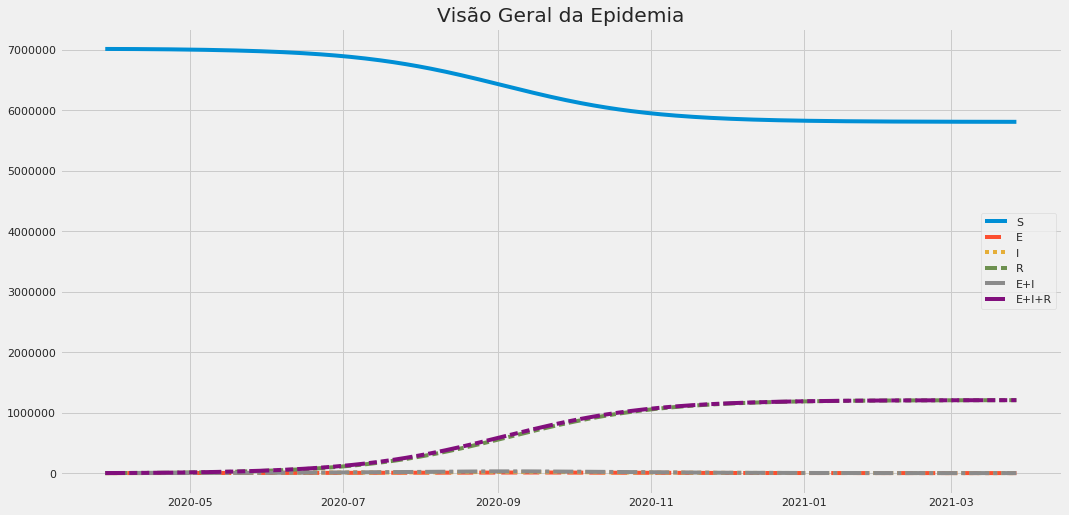

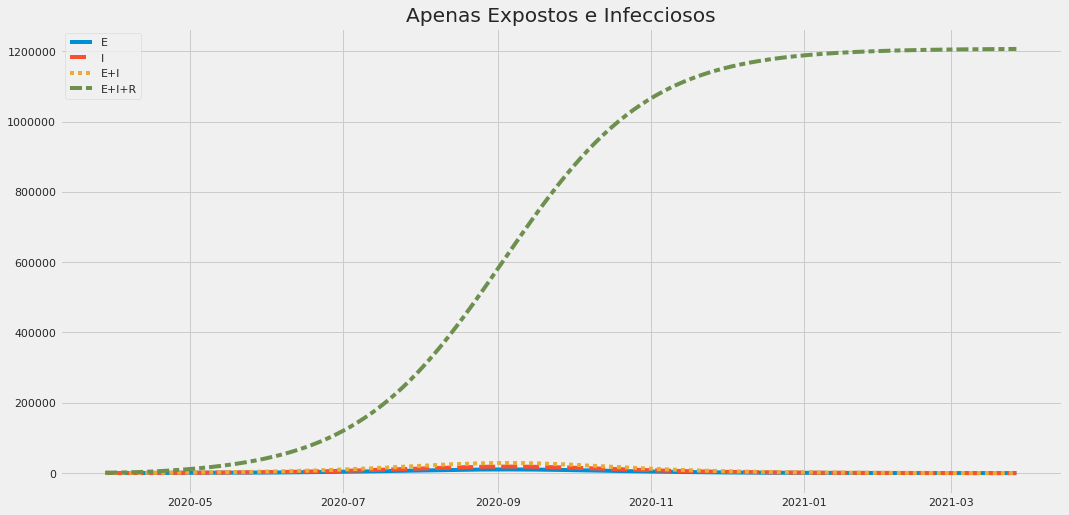

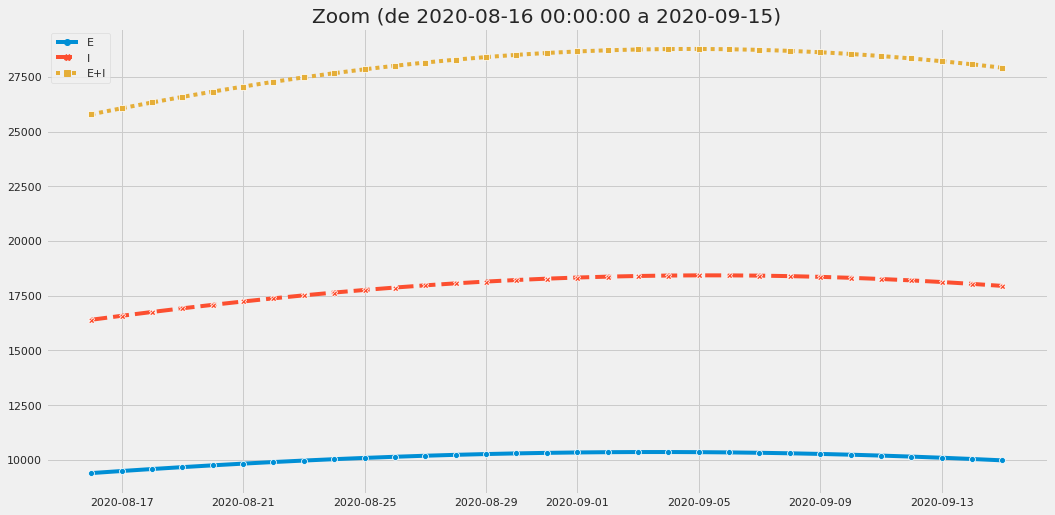

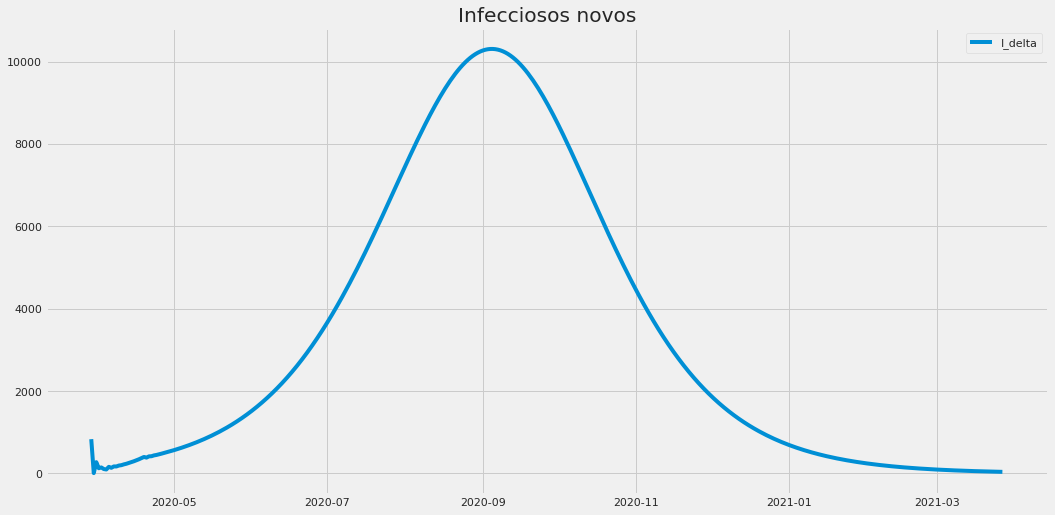

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

1.0962908620325766

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

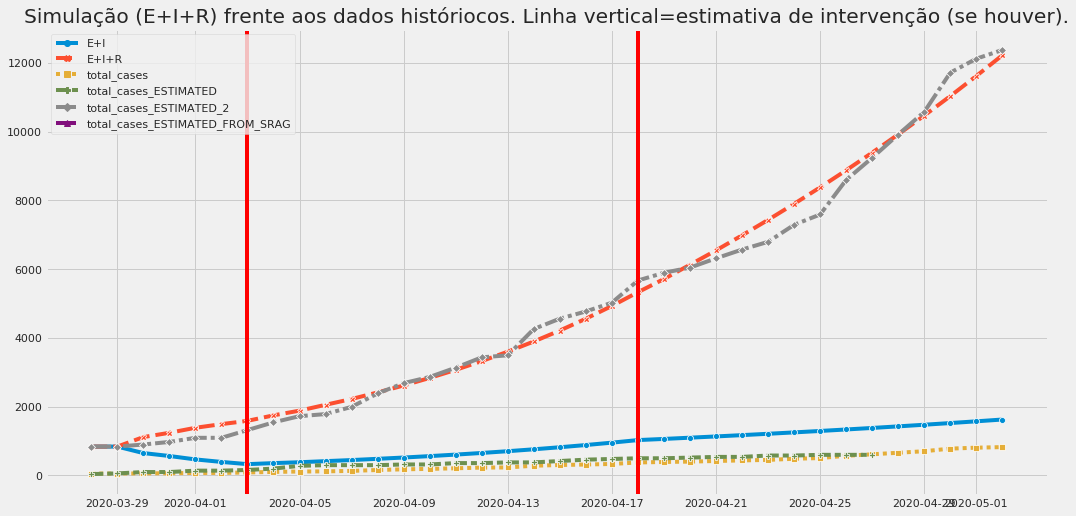

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

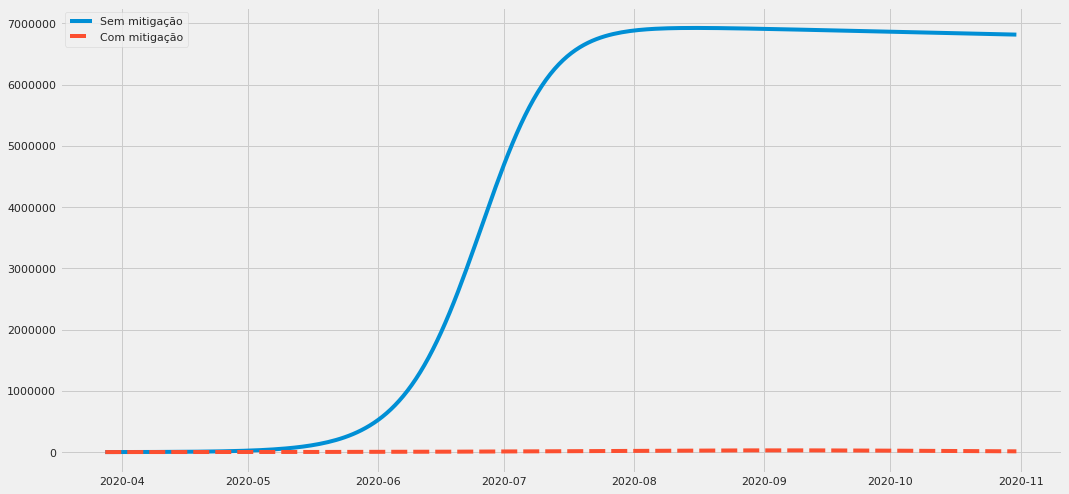

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

38

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.